# Second Report: Financial Market Volatility

By: Abigail Alpert and Gabi Wurgaft

# Project Goal

Predict volatility for the following day for AAPL, LLY, and BEP stocks.

# Current Project Stage

Data Exploration and descriptive analytics

In [6]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

import datetime

# Models
import pmdarima as pm
from pmdarima.arima import auto_arima
from arch import arch_model

# Evaluation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

Structure:

- Data management
- Summary statistics
- Time series plots
- Returns
- Variance
- Volatility
    - Daily volatility
    - Aggregated volatility
- Correlation
- EWMA
- Outlier detection
- Next steps


# Data Management

In [3]:
# Read Data
aapl_df = pd.read_csv("data_files/AAPL_combined.csv.gz")
lly_df = pd.read_csv("data_files/LLY_combined.csv.gz")
bep_df = pd.read_csv("data_files/BEP_combined.csv.gz")
nee_df = pd.read_csv("data_files/NEE_combined.csv.gz")


# Data Preprocessing
def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl_df = data_preprocess(aapl_df)
lly_df = data_preprocess(lly_df)
bep_df = data_preprocess(bep_df)
nee_df = data_preprocess(nee_df)


# Summary Statistics

In [3]:
aapl_df.describe()

timestamp           open           high  \
count                         562931  562931.000000  562931.000000   
mean   2022-11-14 21:03:20.477216768     160.515991     160.593207   
min              2020-01-02 09:30:00      51.539100      51.672300   
25%              2021-06-09 11:06:30     130.567100     130.630900   
50%              2022-11-11 10:26:00     160.717500     160.820600   
75%              2024-04-23 10:26:30     190.944100     191.003600   
max              2025-09-30 15:59:00     259.008600     265.706100   
std                              NaN      45.624113      45.636280   

                 low          close        volume  
count  562931.000000  562931.000000  5.629310e+05  
mean      160.437746     160.516211  1.647944e+05  
min        51.476200      51.529400  6.000000e+00  
25%       130.504700     130.565450  6.793800e+04  
50%       160.624200     160.718600  1.116850e+05  
75%       190.879900     190.944100  1.919780e+05  
max       258.809300     259.028400  2.035834e+07  
std        45.611705      45.624154  2.178602e+05

Notice that the stock price varies by about $200 over the full dataframe. Since our data is on a minute level, the values do not differ too much between the open, high, low, and close prices.

In [4]:
lly_df.describe()

timestamp           open           high  \
count                         558186  558186.000000  558186.000000   
mean   2022-11-13 02:29:51.056314112     433.285002     433.485025   
min              2020-01-02 09:31:00     109.690000     109.971000   
25%              2021-06-07 13:27:15     208.908500     208.970800   
50%              2022-11-09 10:45:30     323.250800     323.396450   
75%              2024-04-19 13:40:45     733.159150     733.555975   
max              2025-09-30 15:59:00     964.839100     965.136800   
std                              NaN     264.277398     264.407444   

                 low          close        volume  
count  558186.000000  558186.000000  5.581860e+05  
mean      433.081830     433.283493  5.859736e+03  
min       109.643100     109.821100  1.000000e+00  
25%       208.842600     208.890500  1.717000e+03  
50%       323.113400     323.259600  3.252000e+03  
75%       732.695800     733.151675  6.246000e+03  
max       963.310800     964.610700  1.246834e+06  
std       264.144637     264.275595  1.108389e+04

Notice that the stock price varies by about $850 over the full dataframe. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [5]:
bep_df.describe()

timestamp           open           high  \
count                         401488  401488.000000  401488.000000   
mean   2022-11-08 15:37:05.745377024      25.741919      25.750977   
min              2020-01-02 09:30:00      12.429000      12.449800   
25%              2021-05-03 14:49:45      22.239900      22.246400   
50%              2022-11-02 15:31:30      24.789400      24.795600   
75%              2024-05-03 14:42:15      29.526100      29.535600   
max              2025-09-30 15:59:00      39.598300      39.598300   
std                              NaN       4.781916       4.782594   

                 low          close         volume  
count  401488.000000  401488.000000  401488.000000  
mean       25.732866      25.741928    1495.447027  
min        12.388100      12.429300       1.000000  
25%        22.230300      22.239900     261.000000  
50%        24.782100      24.790000     628.000000  
75%        29.519200      29.527400    1549.000000  
max        39.534800      39.550700  423712.000000  
std         4.781305       4.781990    3329.225258

Notice that the stock prices varies by about $35 over the full dataframe. This is considerably less than the other stocks that we are looking at. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

# Time Series Plot

In [6]:
def plot_timeseries(df, column, stock):
    g = (ggplot(df) + 
         geom_line(aes(x='timestamp', y=column)) + 
         labs(title=f"{stock}: {column} price"))
    return g
def plot_timeseries_grid(df, columns, stock):
    n = len(columns)
    ncols = 2
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        g = plot_timeseries(df, column, stock)
        g.draw(axes[i])
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Apple Plots

Although there is a general upwards trend over time, the increase in stock price is not consistent

In [7]:
plot_timeseries(aapl_df, ['open','close'], "AAPL")

PlotnineError: 'Aesthetics must either be length one, or the same length as the data'

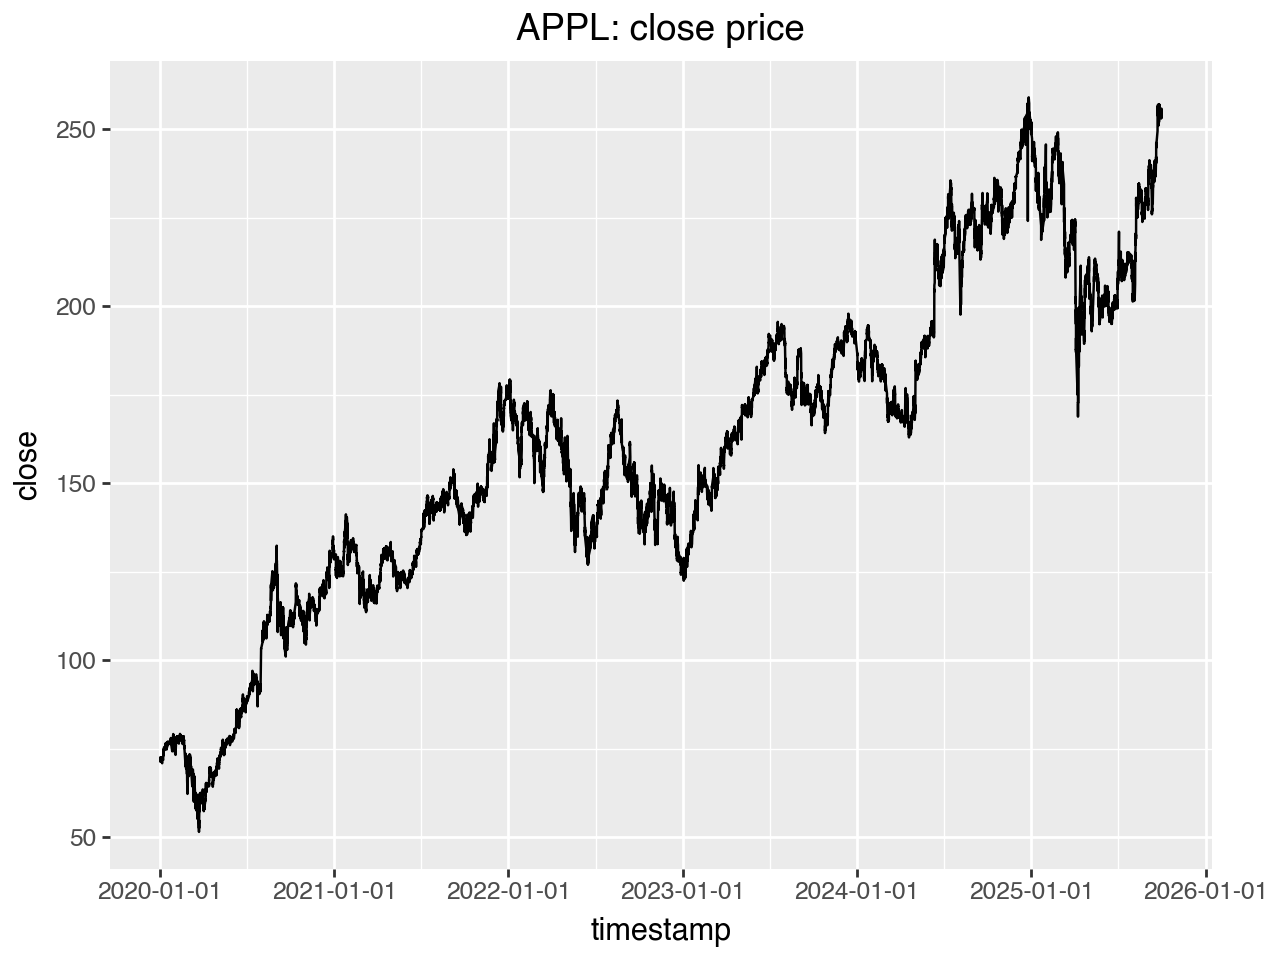

In [8]:
plot_timeseries(aapl_df, 'close', "APPL")

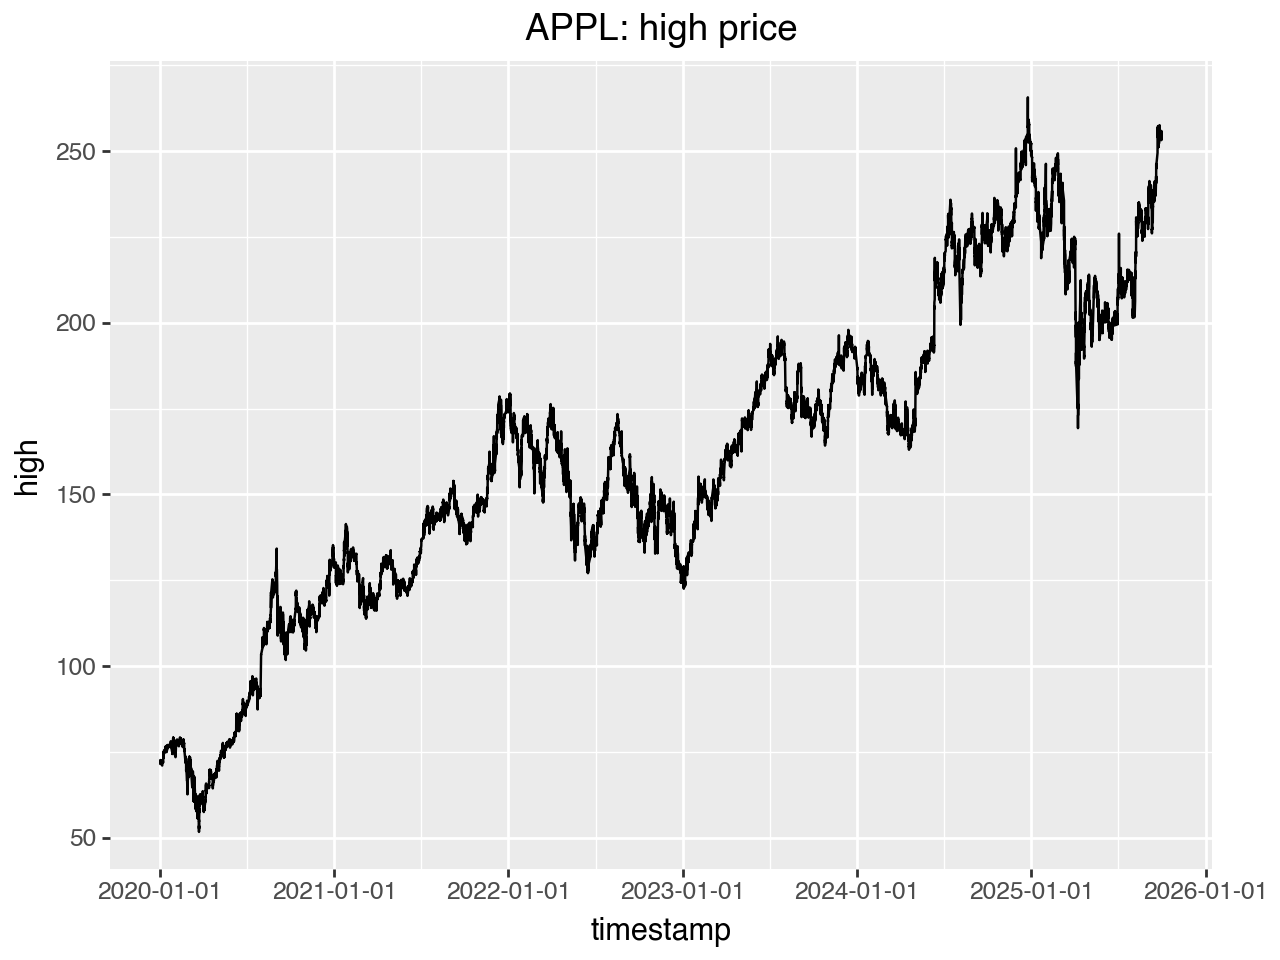

In [9]:
plot_timeseries(aapl_df, 'high', "APPL")


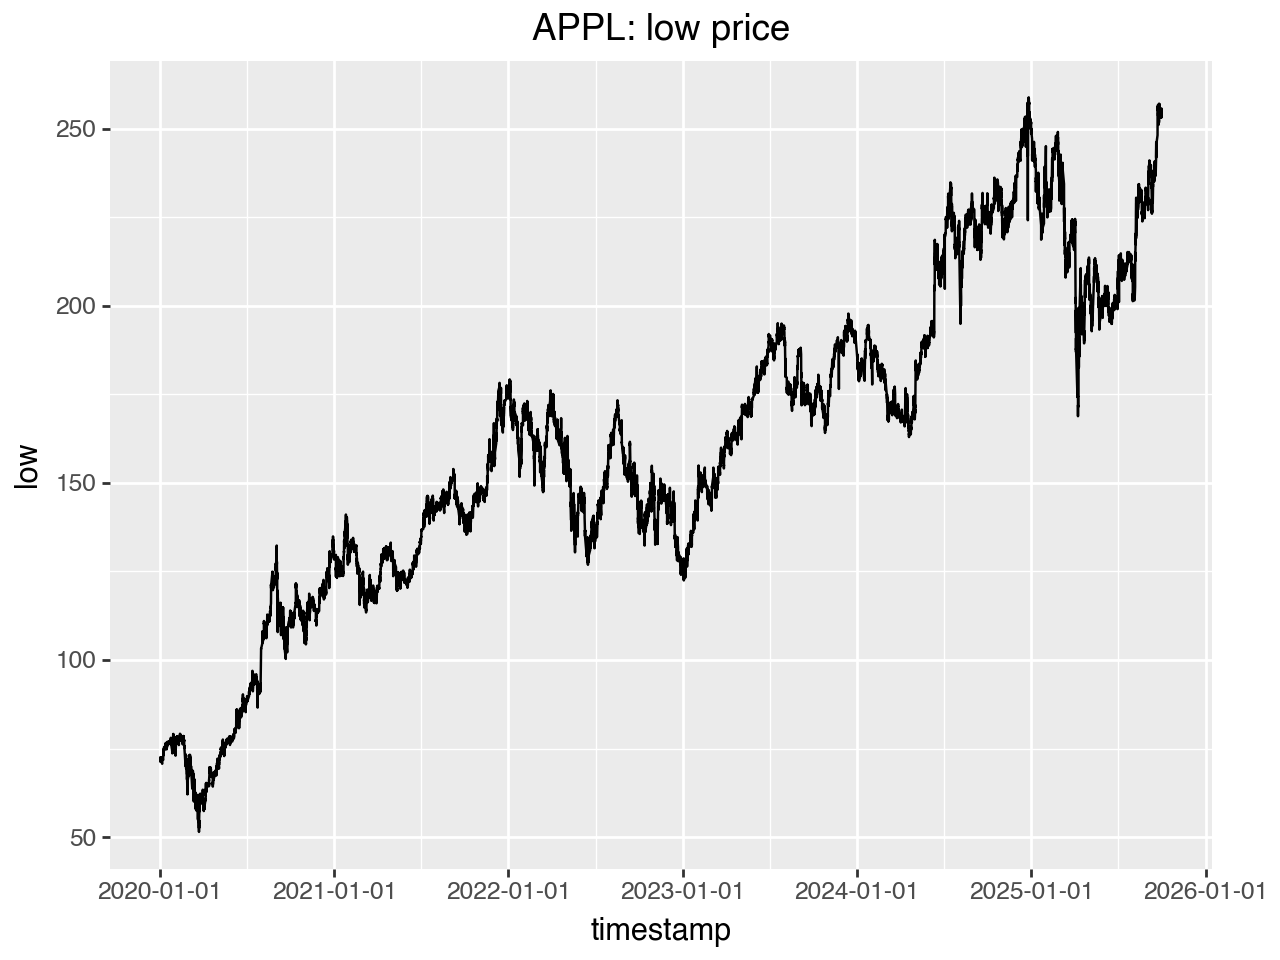

In [10]:
plot_timeseries(aapl_df, 'low', "APPL")

### Eli Lilly Plots

Notice that the stock price was increasing steadily until March 2023 when the price increased dramatically. Since June 2024, the LLY stock price has been on a general decreasing trend

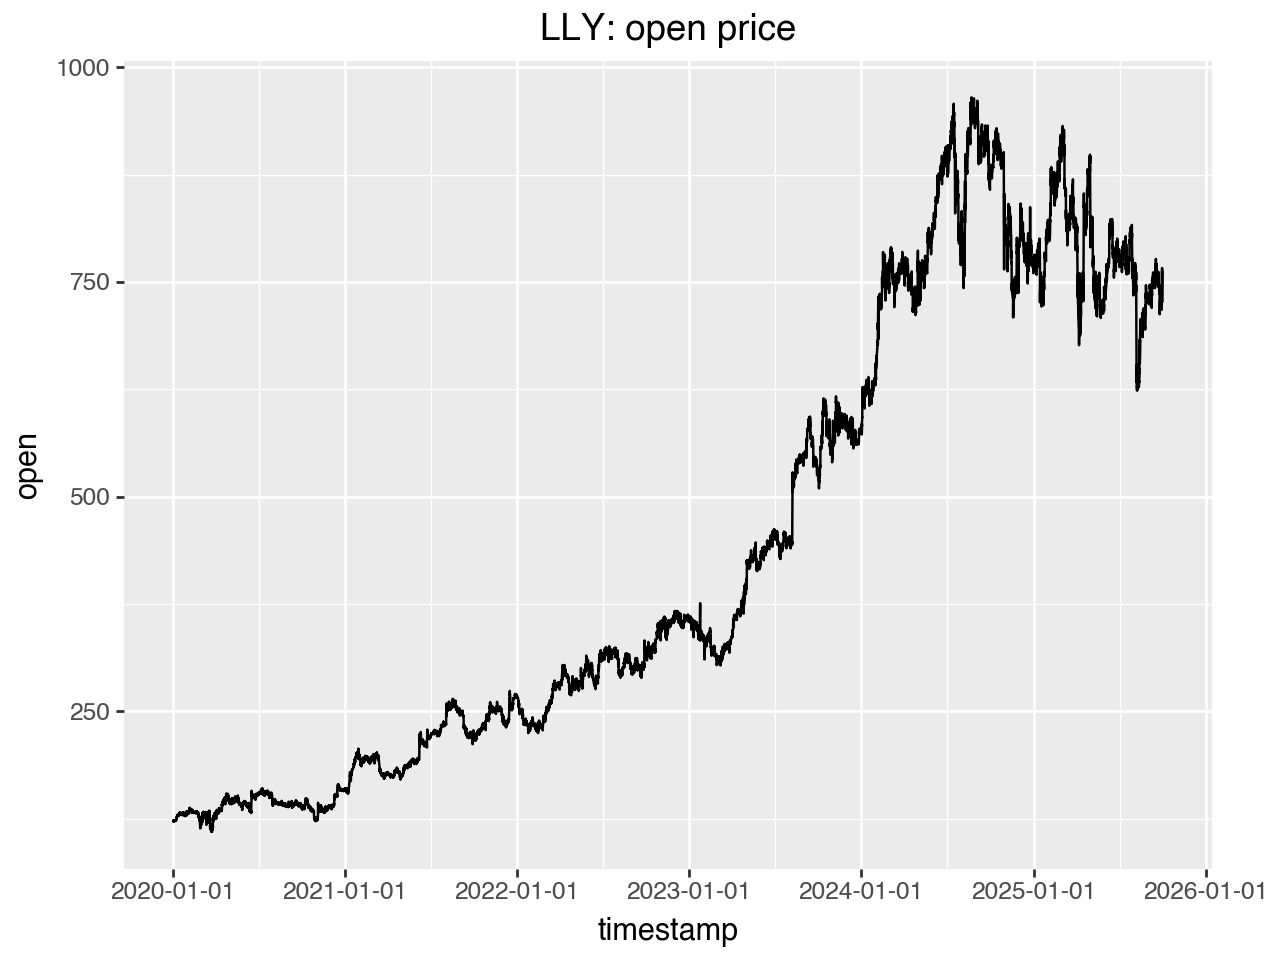

In [11]:
plot_timeseries(lly_df, 'open', 'LLY')

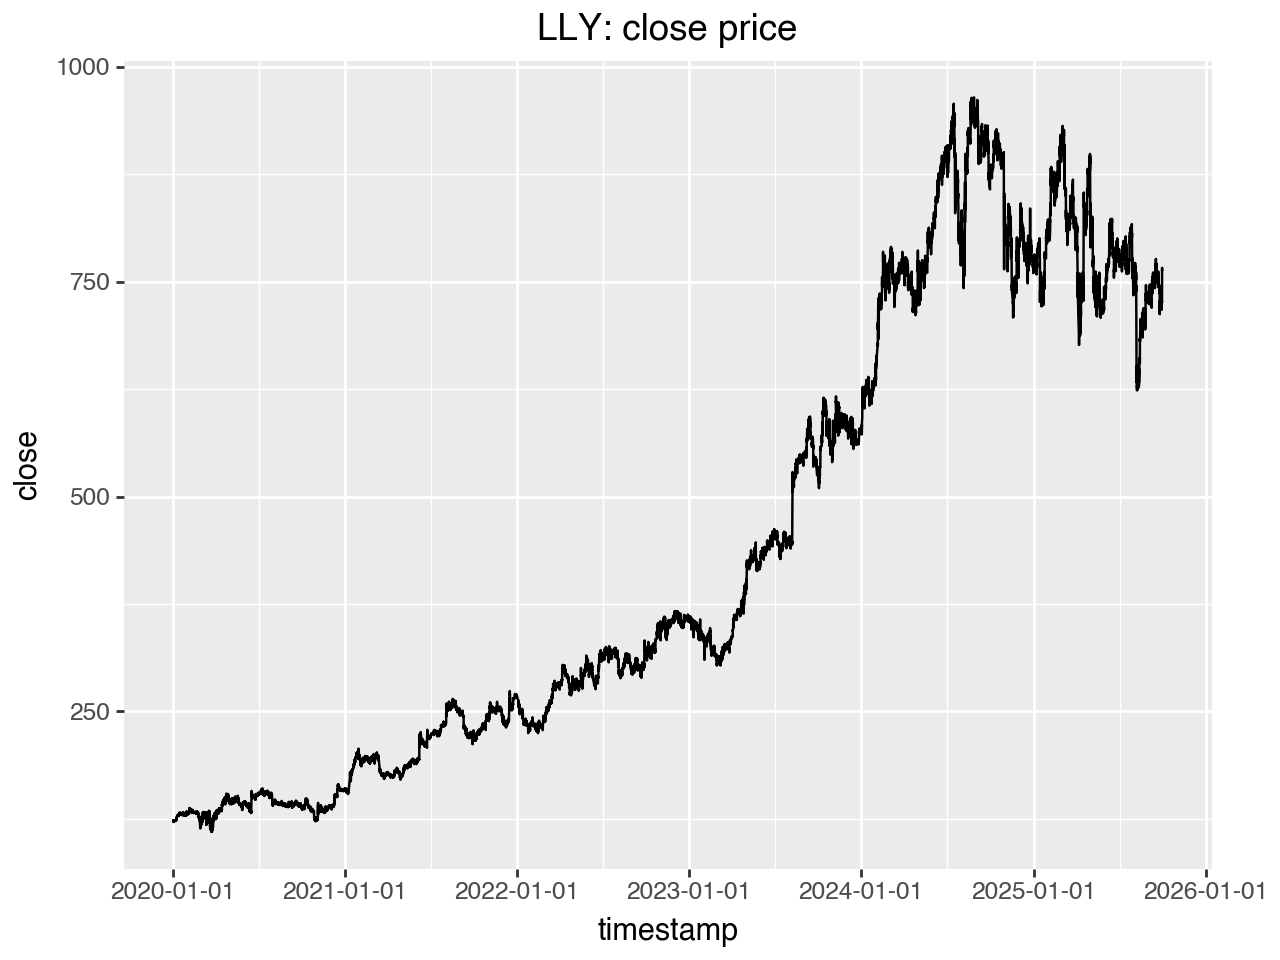

In [12]:
plot_timeseries(lly_df, 'close', 'LLY')

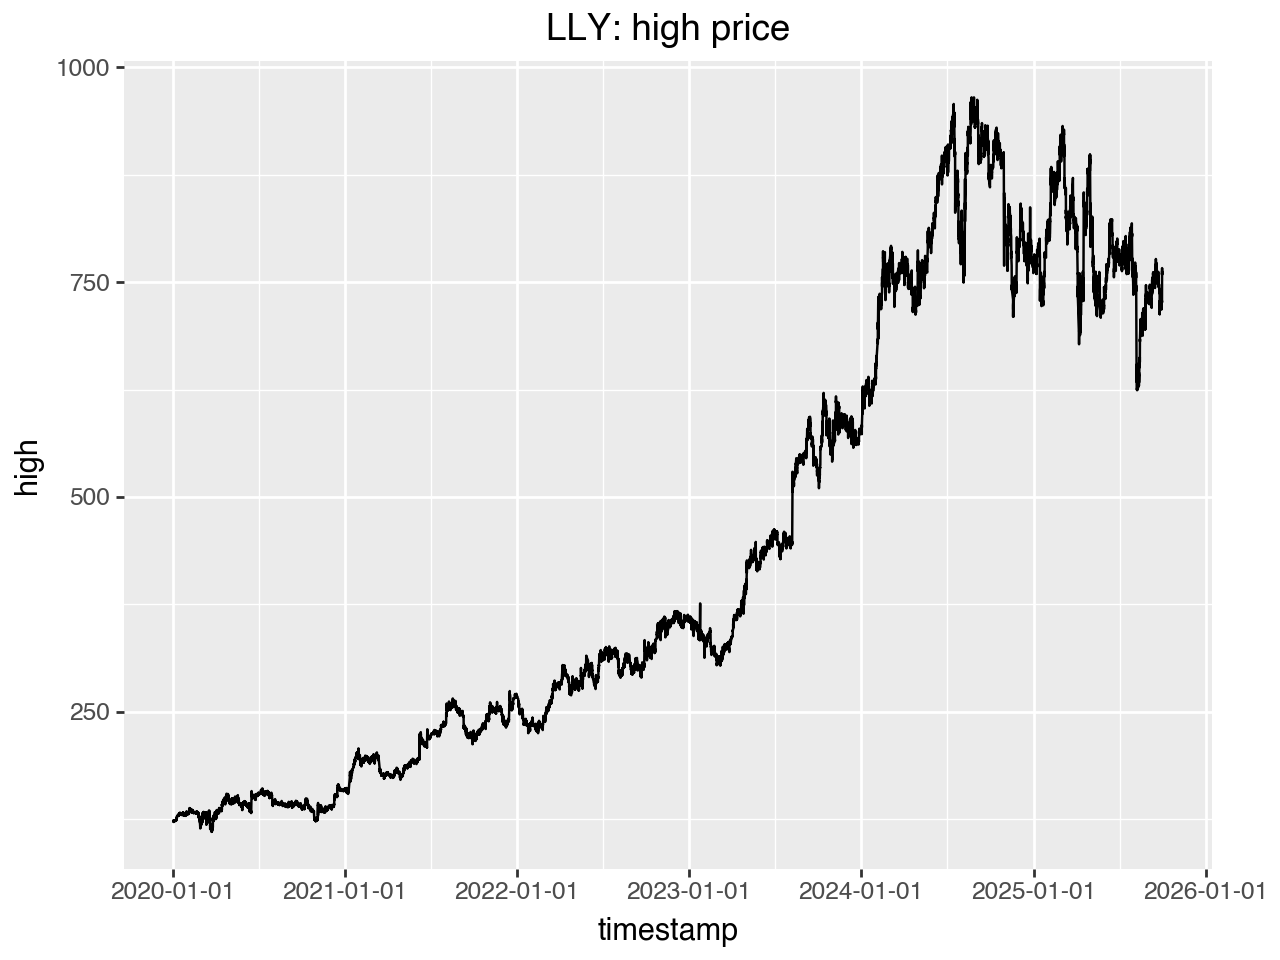

In [13]:
plot_timeseries(lly_df, 'high', 'LLY')

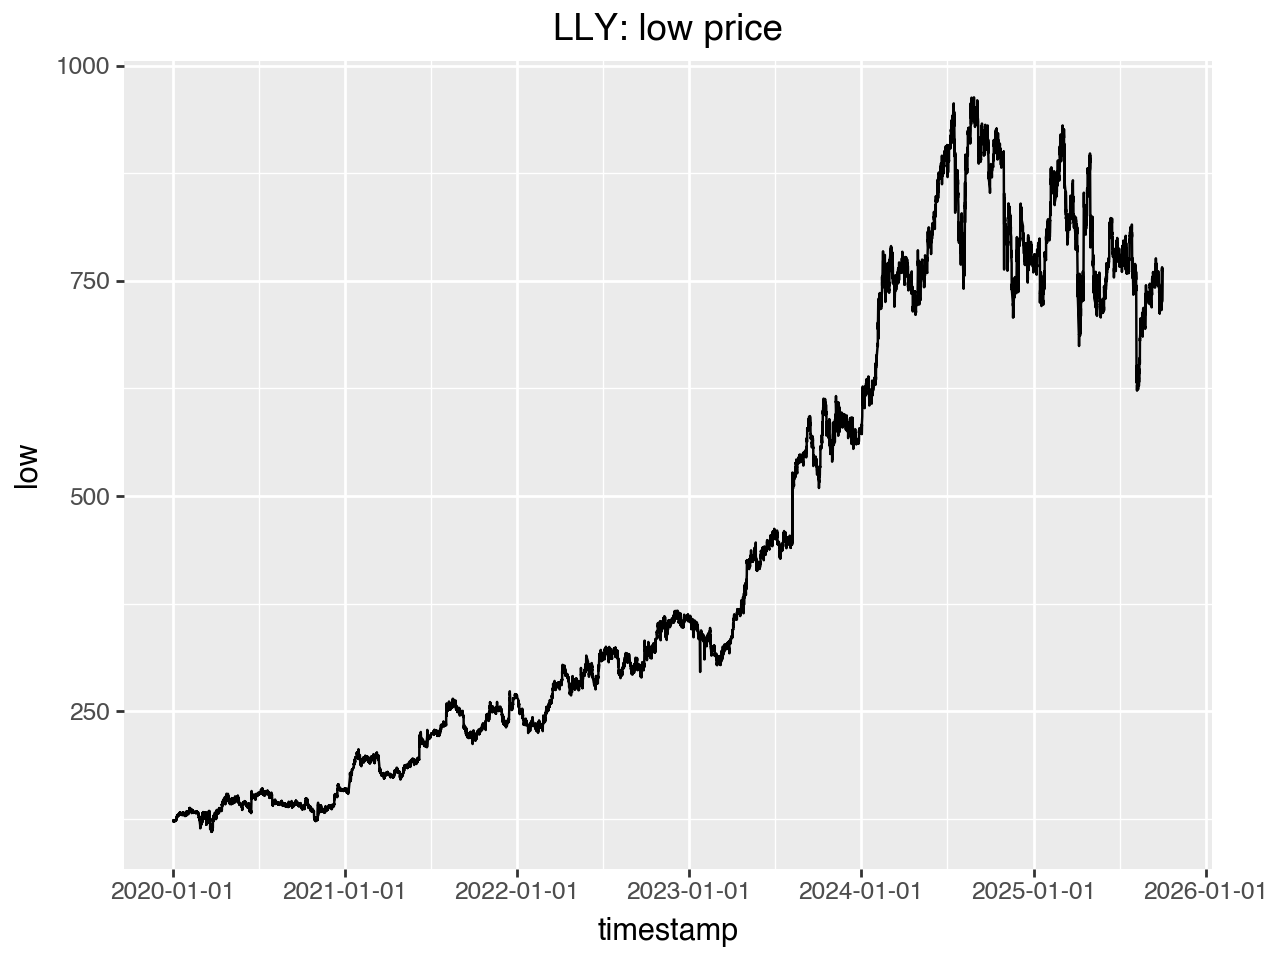

In [14]:
plot_timeseries(lly_df, 'low', 'LLY')

### Brookfield Plots

Notice that the Brookfield stock price shot up dramatically startin in March 2020 through the end of the year. Since then, there have been many flucations, but a general decrease in stock price. Since the start of 2025, the BEP stock prices has been mostly increasing.

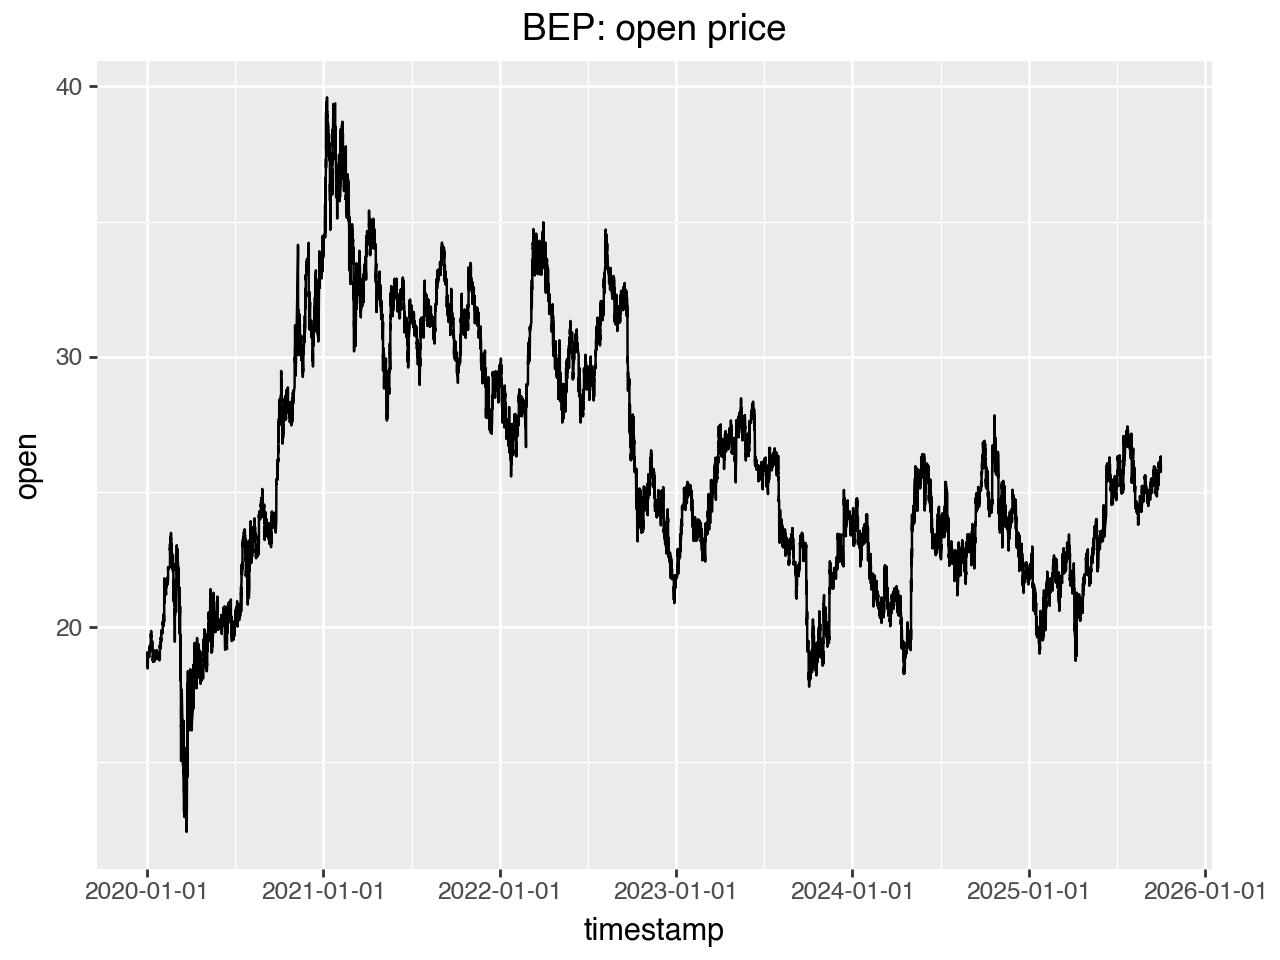

In [15]:
plot_timeseries(bep_df, 'open', 'BEP')

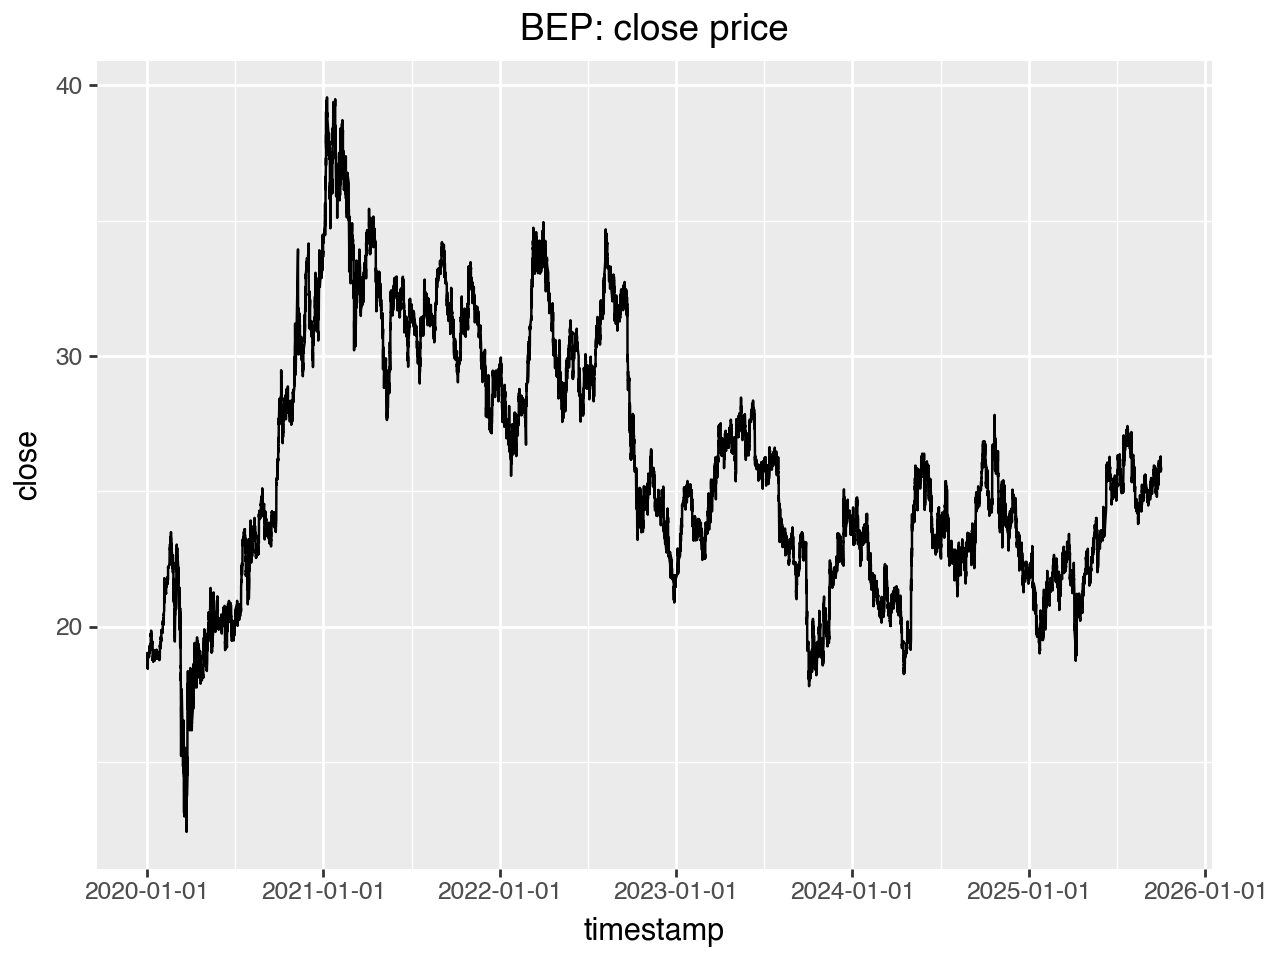

In [16]:
plot_timeseries(bep_df, 'close', 'BEP')

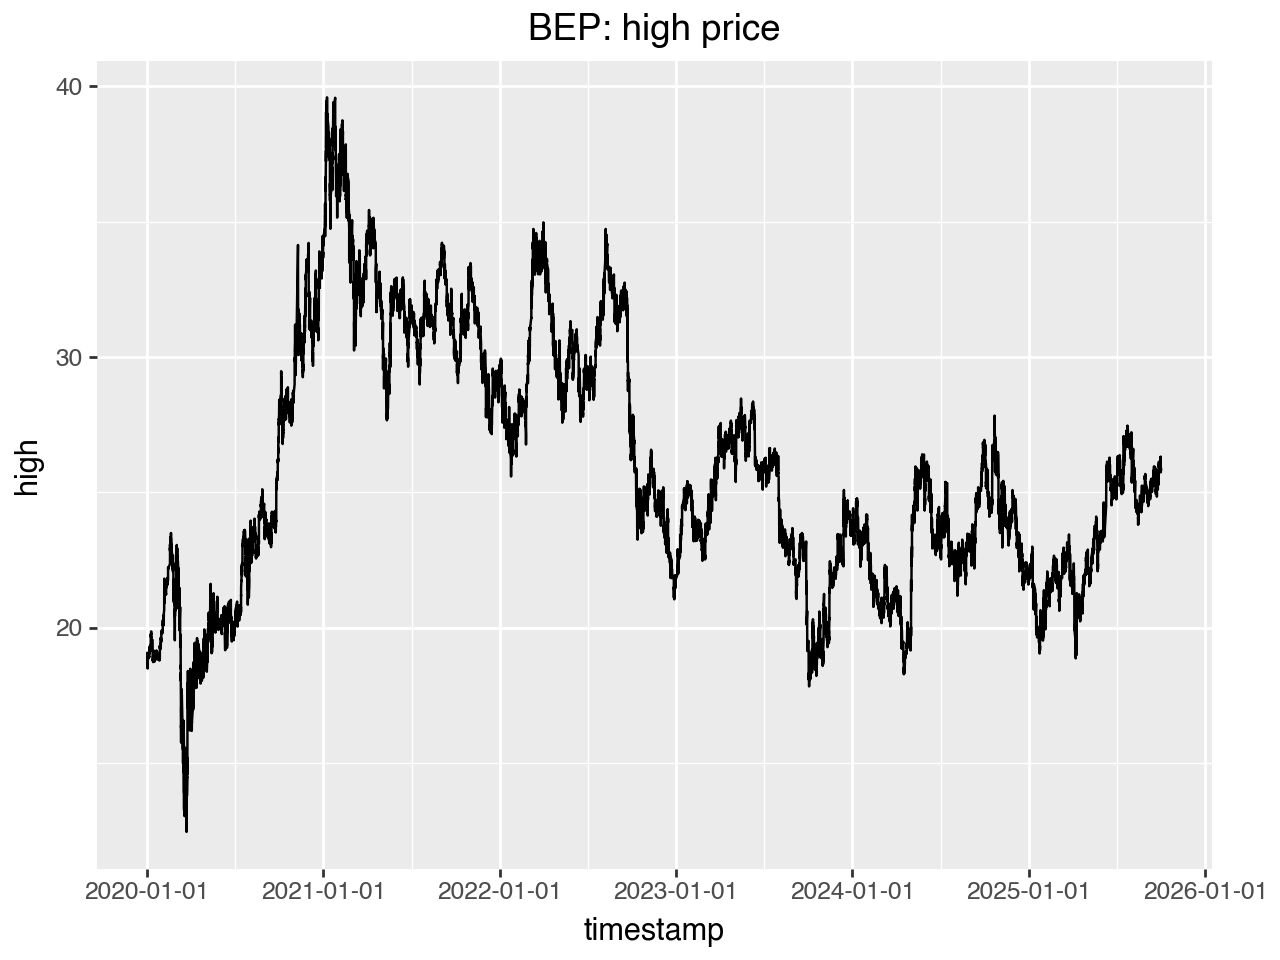

In [17]:
plot_timeseries(bep_df, 'high', 'BEP')

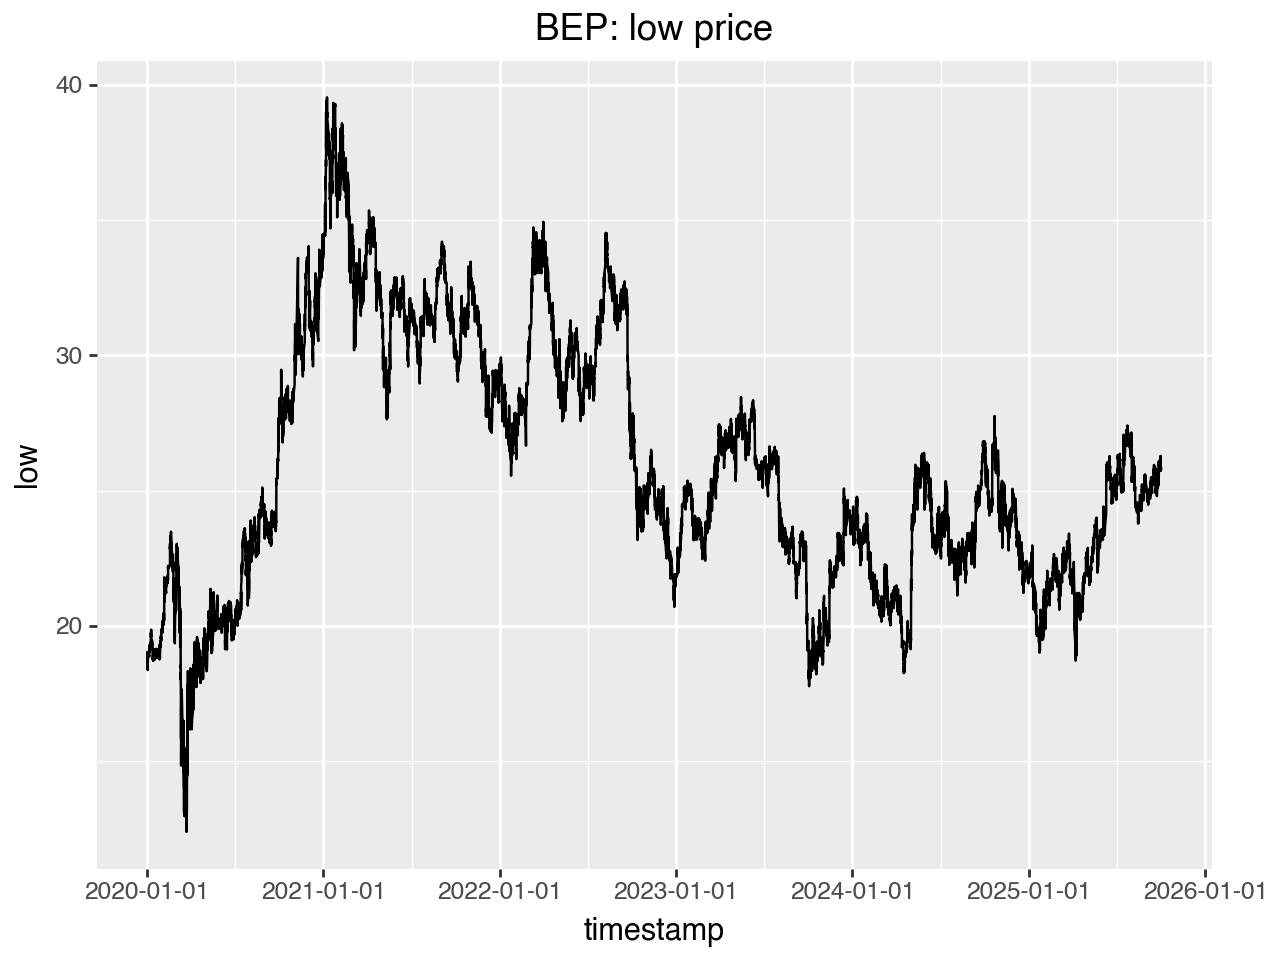

In [18]:
plot_timeseries(bep_df, 'low', 'BEP')

# Returns

In [3]:
#Load in AAPL data, make returns, variance, and volatility
AAPL_returns = pd.DataFrame({
    "time_stamp": aapl_df['timestamp'],
    "log_return": np.log(1+(aapl_df['close']-aapl_df['open'])/aapl_df['open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()


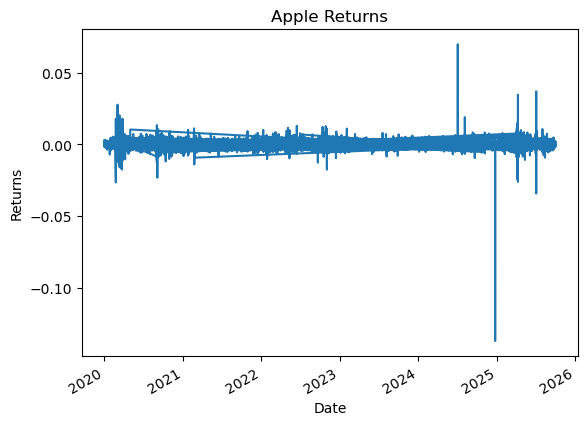

In [4]:
#Plot returns
AAPL_returns.set_index("time_stamp", inplace=True)
AAPL_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns")
plt.show()

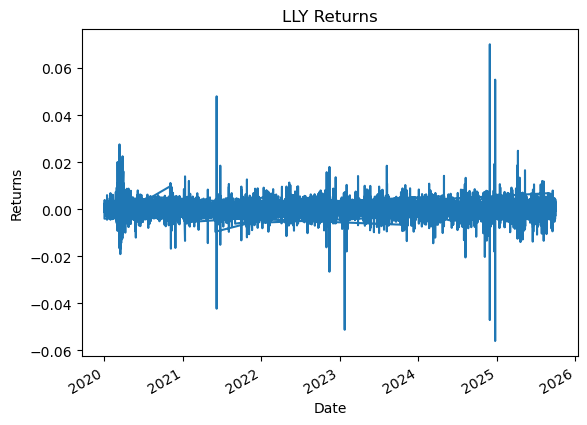

In [5]:
LLY_returns = pd.DataFrame({
    "time_stamp": lly_df["timestamp"],
    "log_return": np.log(1+(lly_df['close']-lly_df['open'])/lly_df['open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

LLY_returns.set_index("time_stamp", inplace=True)
LLY_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns")
plt.show()

In [6]:
BEP_returns = pd.DataFrame({
    "time_stamp": bep_df["timestamp"],
    "log_return": np.log(1+(bep_df['close']-bep_df['open'])/bep_df['open'])
})
BEP_returns['time_stamp'] = pd.to_datetime(BEP_returns['time_stamp'], errors='coerce')
daily_variance_BEP = BEP_returns.groupby(BEP_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

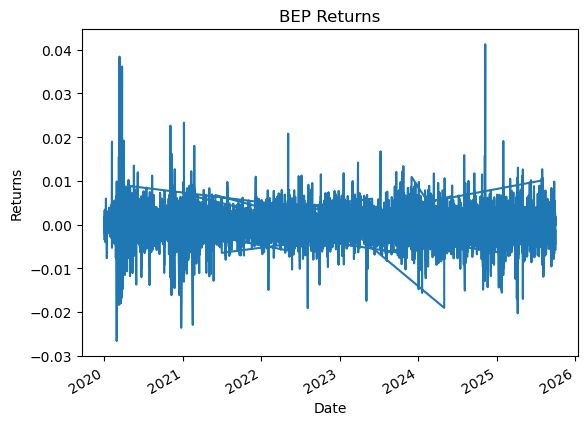

In [7]:
BEP_returns.set_index("time_stamp", inplace=True)
BEP_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("BEP Returns")
plt.show()

# Variance

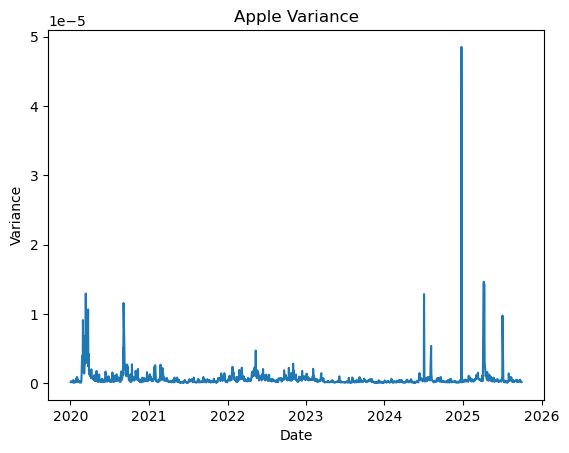

In [8]:
#Plot variance
plt.plot(daily_variance_AAPL.index, daily_variance_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance")
plt.show()

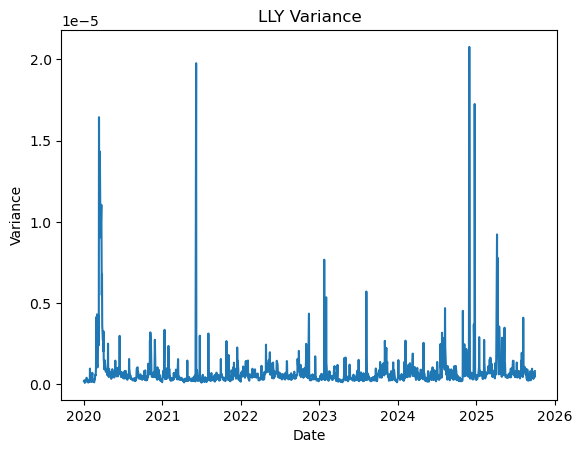

In [9]:
plt.plot(daily_variance_LLY.index, daily_variance_LLY.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance")
plt.show()

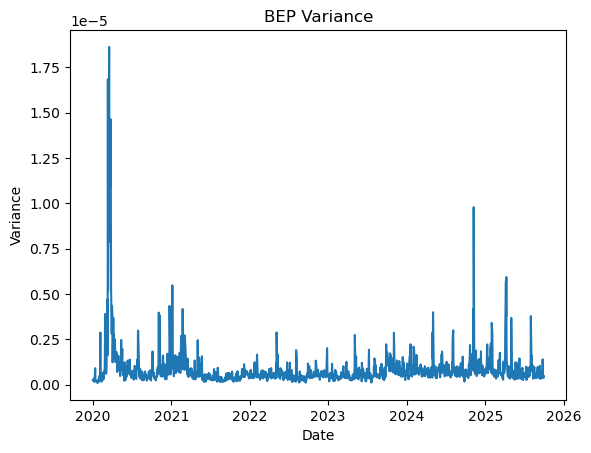

In [10]:
plt.plot(daily_variance_BEP.index, daily_variance_BEP.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("BEP Variance")
plt.show()

# Volatility

## Daily Volatility

Realized Volatility

In [29]:
#Plot volatility
daily_volatility_AAPL = np.sqrt(daily_variance_AAPL)
print(daily_volatility_AAPL)
df = pd.DataFrame(daily_volatility_AAPL)
df = df.rename(columns={'log_return': 'volatility'})
df
# plt.plot(daily_volatility_AAPL.index, daily_volatility_AAPL.values)
# plt.xlabel("Date")
# plt.ylabel("Volatility")
# plt.title("Apple Volatility")
# plt.show()

time_stamp
2020-01-02    0.000447
2020-01-03    0.000564
2020-01-06    0.000436
2020-01-07    0.000453
2020-01-08    0.000482
                ...   
2025-09-24    0.000509
2025-09-25    0.000627
2025-09-26    0.000486
2025-09-29    0.000423
2025-09-30    0.000454
Name: log_return, Length: 1444, dtype: float64


volatility
time_stamp            
2020-01-02    0.000447
2020-01-03    0.000564
2020-01-06    0.000436
2020-01-07    0.000453
2020-01-08    0.000482
...                ...
2025-09-24    0.000509
2025-09-25    0.000627
2025-09-26    0.000486
2025-09-29    0.000423
2025-09-30    0.000454

[1444 rows x 1 columns]

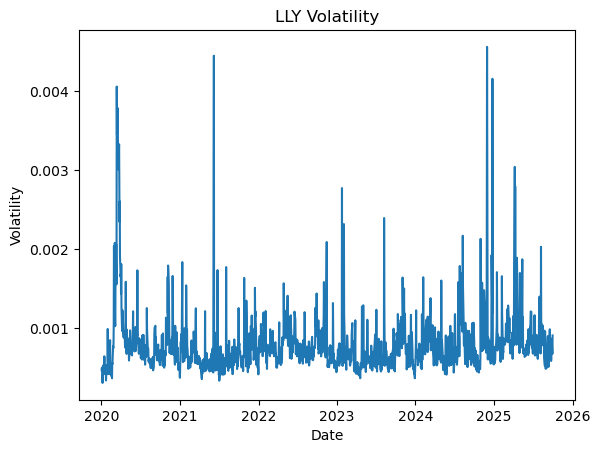

In [12]:
daily_volatility_LLY = np.sqrt(daily_variance_LLY)
plt.plot(daily_volatility_LLY.index, daily_volatility_LLY.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility")
plt.show()

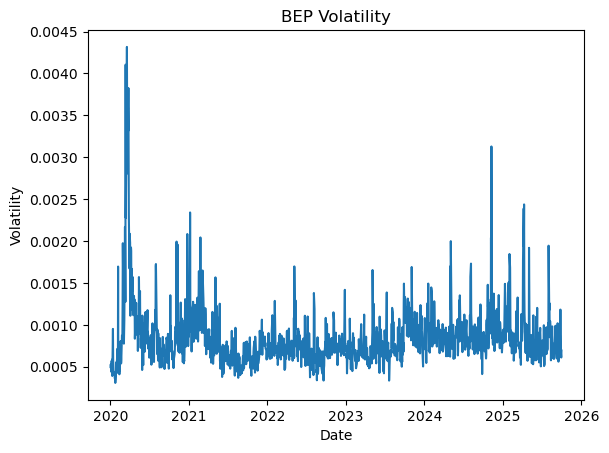

In [13]:
daily_volatility_BEP = np.sqrt(daily_variance_BEP)
plt.plot(daily_volatility_BEP.index, daily_volatility_BEP.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("BEP Volatility")
plt.show()

## Aggregated Volatility

Value ranges

In [30]:
def resample_data(df, frequency):
    agg_funcs = {'open': 'mean',
                 'close': 'mean',
                 'high': 'max',
                 'low': 'min',
                 'volume': 'sum'}
    
    df = df.set_index('timestamp')

    resampled_df = df.resample(frequency).agg(agg_funcs)
    
    resampled_df = resampled_df.reset_index()

    return resampled_df

def volatility_df(df, frequency):
    
    resampled_df = resample_data(df, frequency)

    resampled_df['open-close'] = resampled_df['open'] - resampled_df['close']
    resampled_df['high-low'] = resampled_df['high'] - resampled_df['low']
    
    return resampled_df

time_intervals = ['1H', '1D', 'W', '1M', 'Q', 'Y'] # day, month, week, month, quarter, year

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


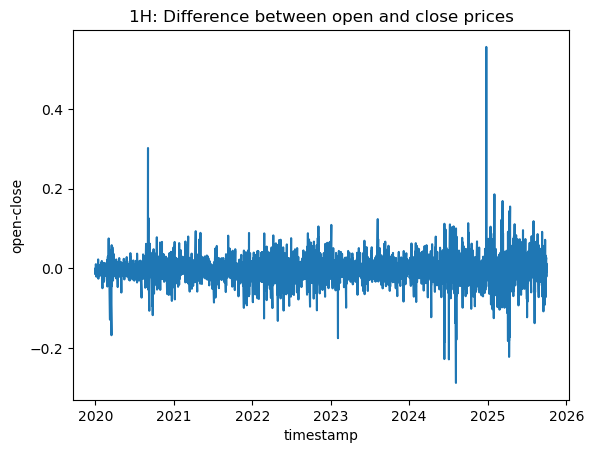

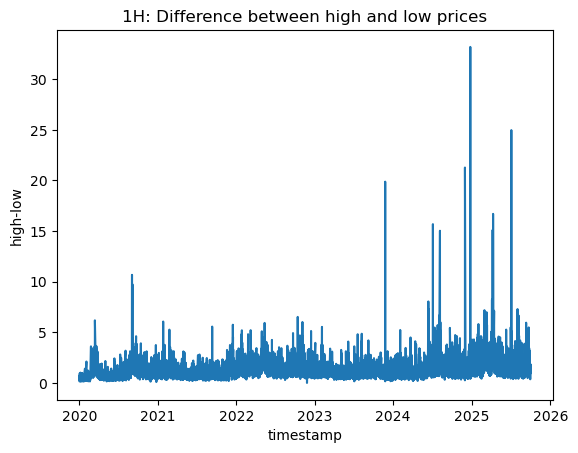

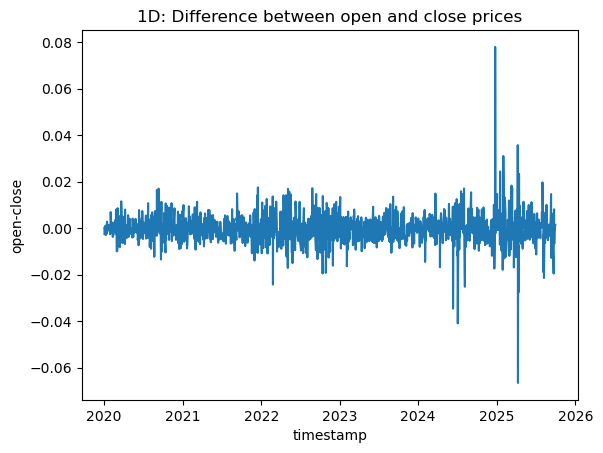

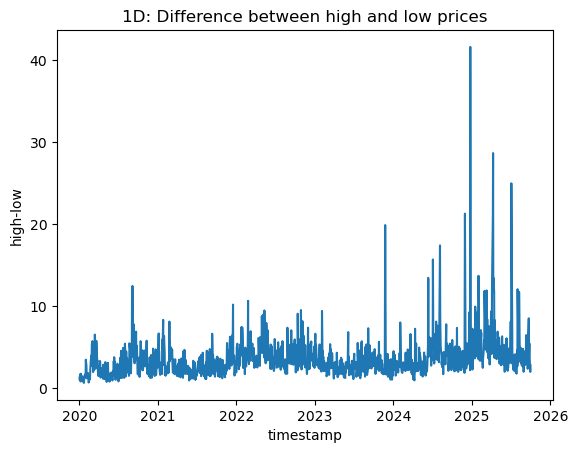

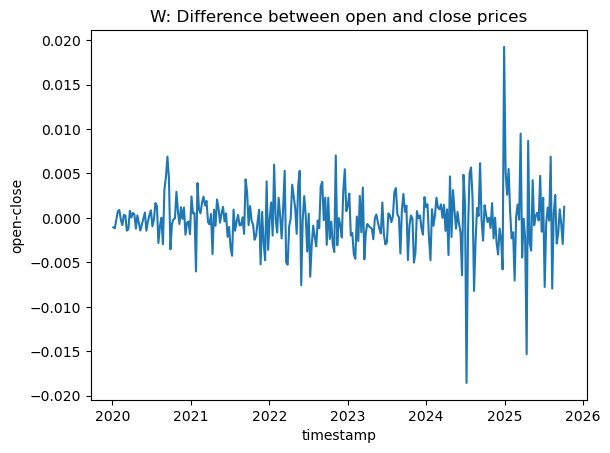

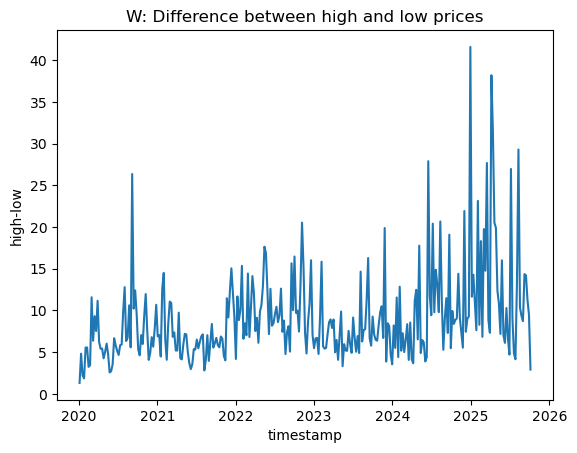

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


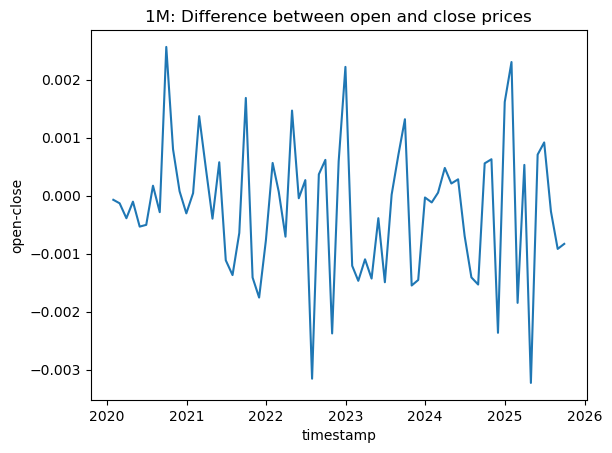

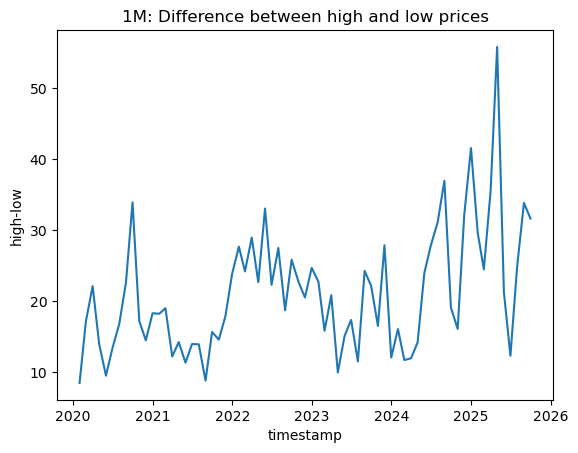

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


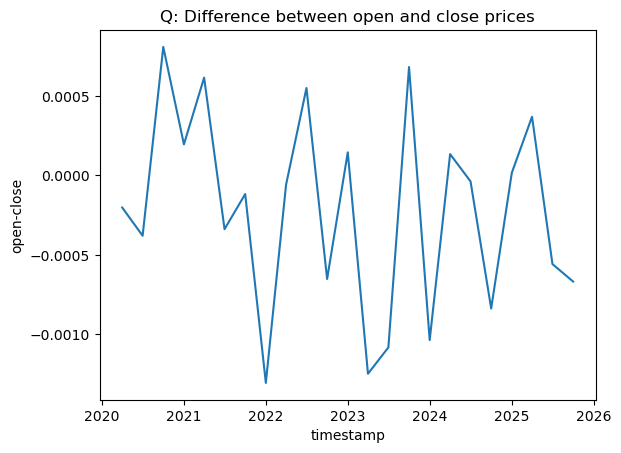

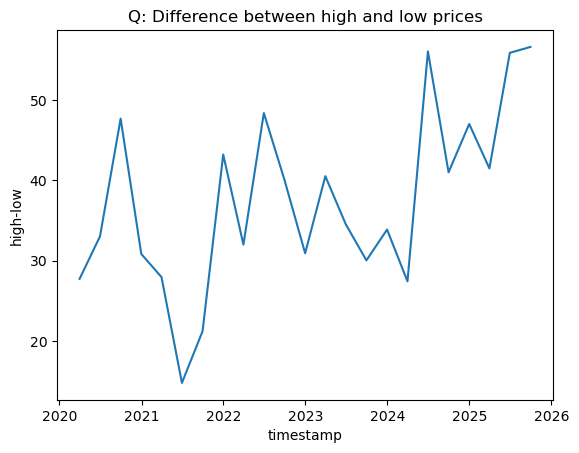

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


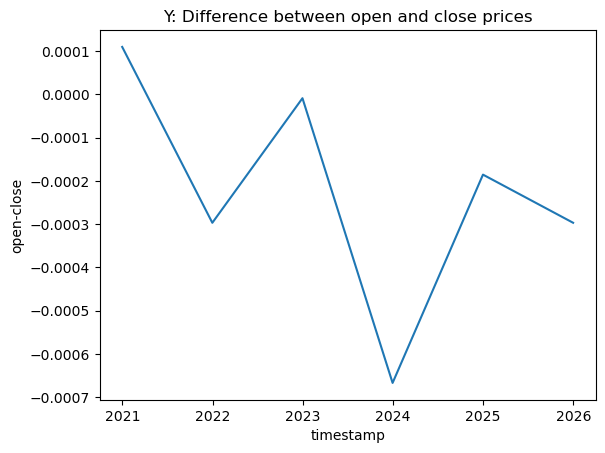

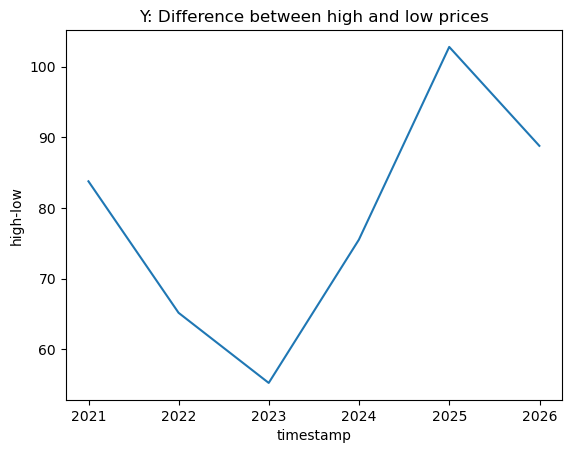

In [31]:
for inter in time_intervals:
    aapl_ranges = volatility_df(aapl_df, inter)

    plt.figure()
    sns.lineplot(data=aapl_ranges, x='timestamp', y='open-close')
    plt.title(f'{inter}: Difference between open and close prices')
    plt.show()

    plt.figure()
    sns.lineplot(data=aapl_ranges, x='timestamp', y='high-low')
    plt.title(f'{inter}: Difference between high and low prices')
    plt.show()

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


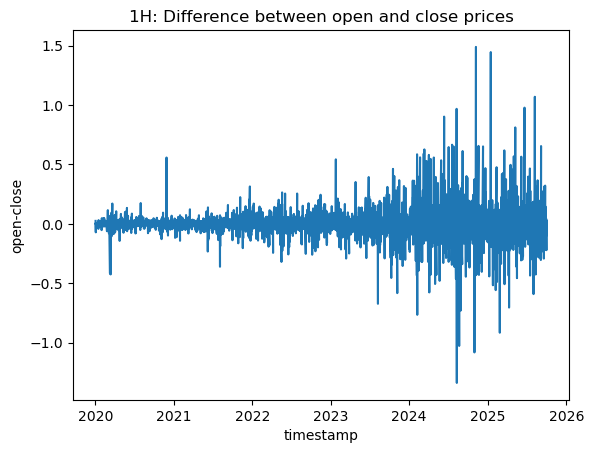

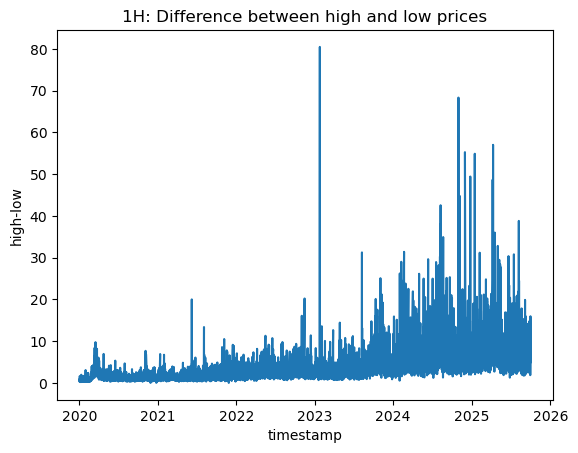

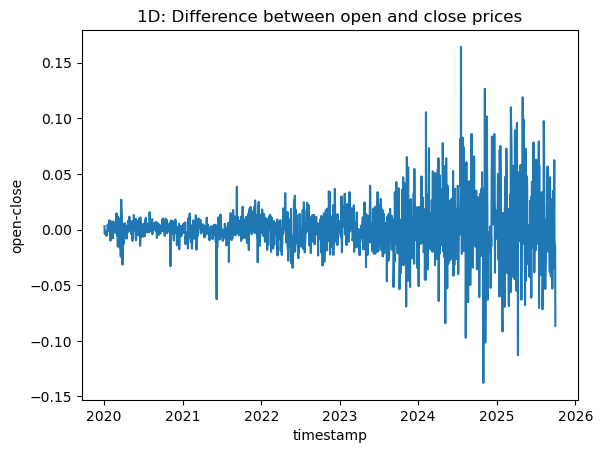

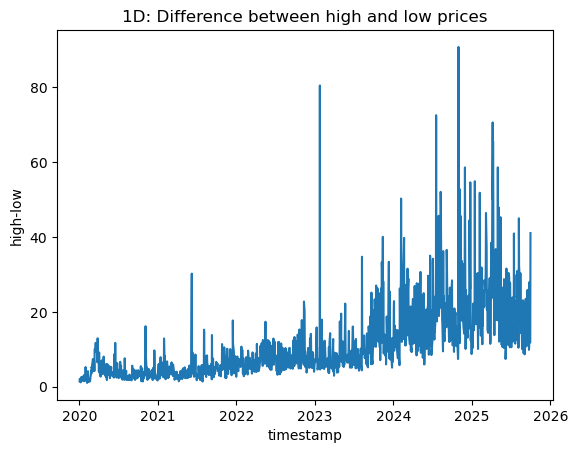

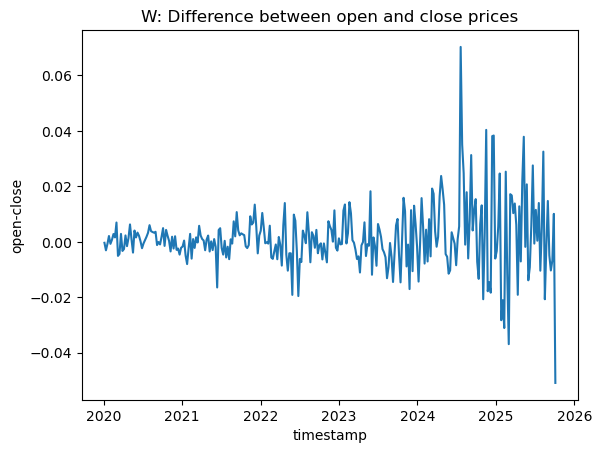

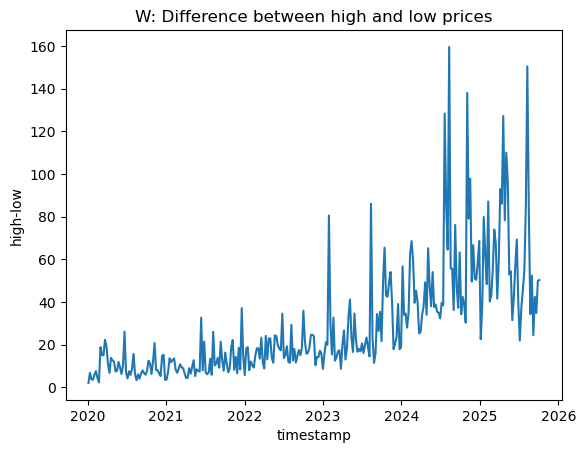

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


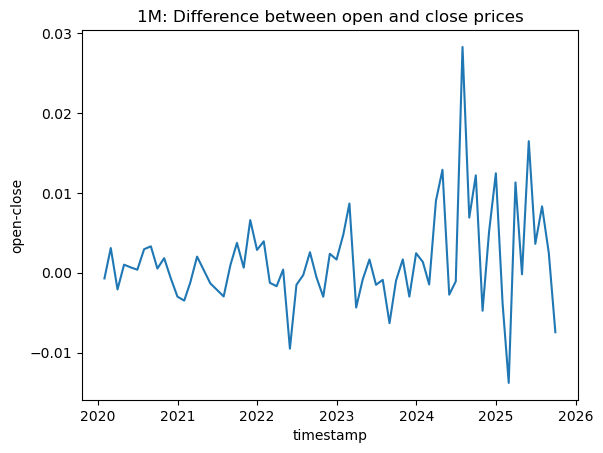

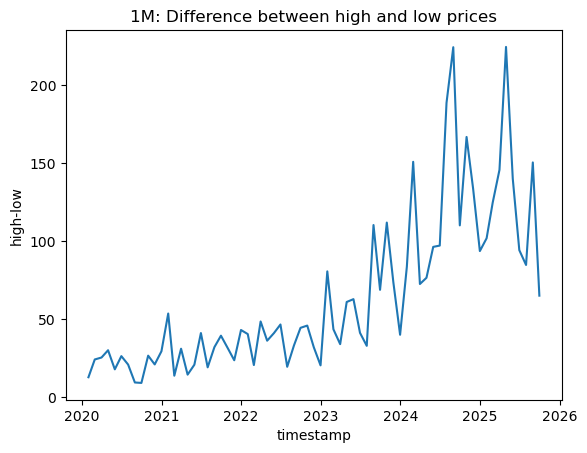

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


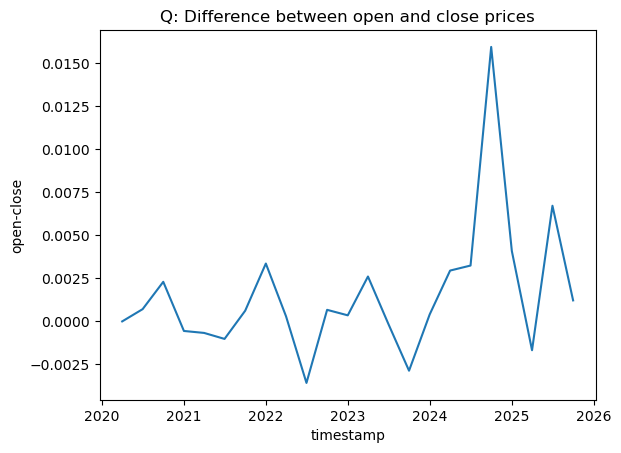

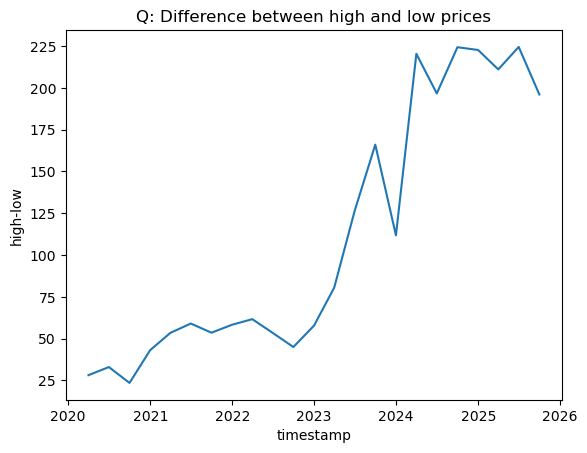

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


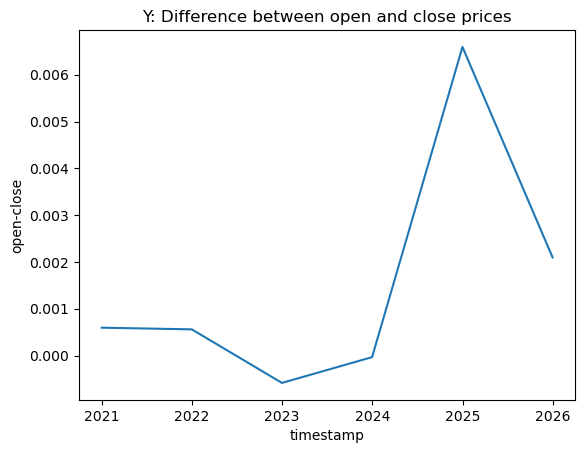

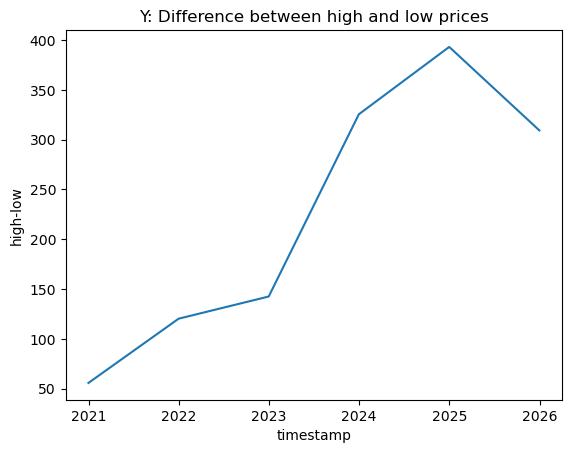

In [32]:
 for inter in time_intervals:
    lly_ranges = volatility_df(lly_df, inter)

    plt.figure()
    sns.lineplot(data=lly_ranges, x='timestamp', y='open-close')
    plt.title(f'{inter}: Difference between open and close prices')
    plt.show()

    plt.figure()
    sns.lineplot(data=lly_ranges, x='timestamp', y='high-low')
    plt.title(f'{inter}: Difference between high and low prices')
    plt.show()

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


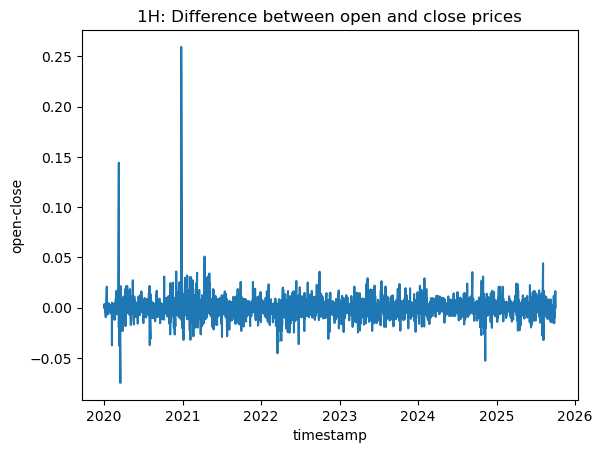

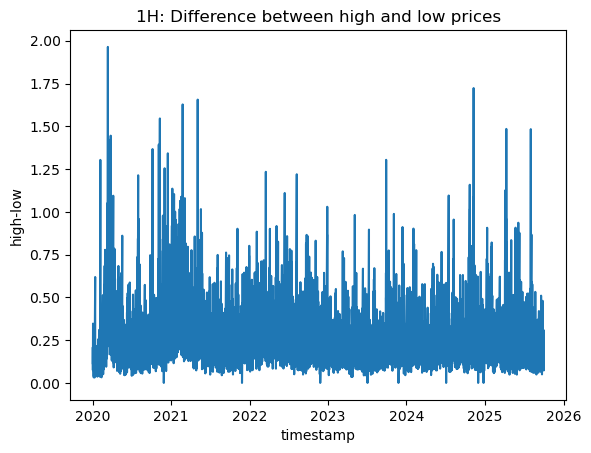

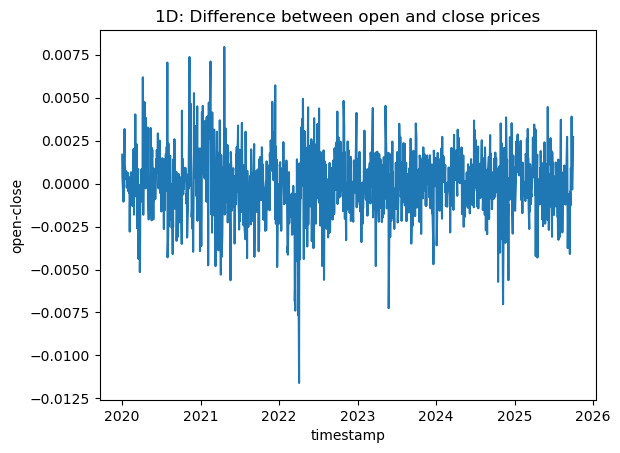

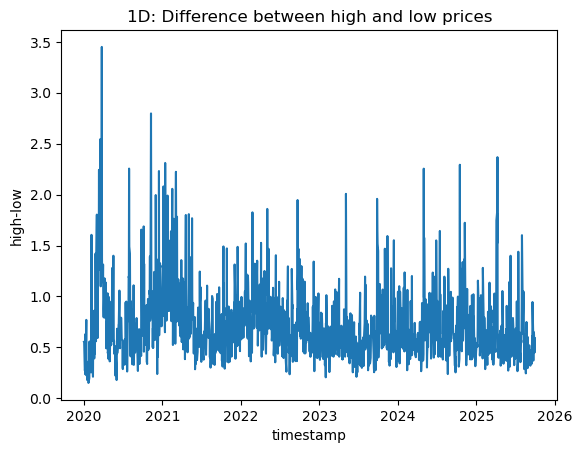

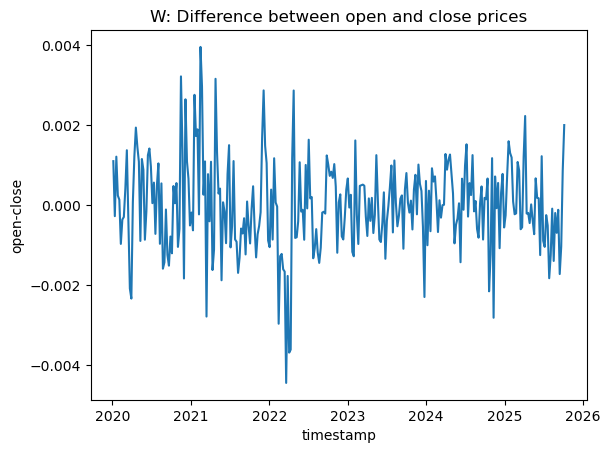

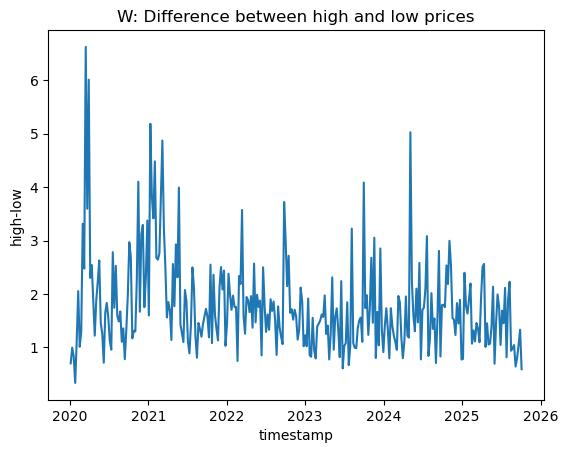

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


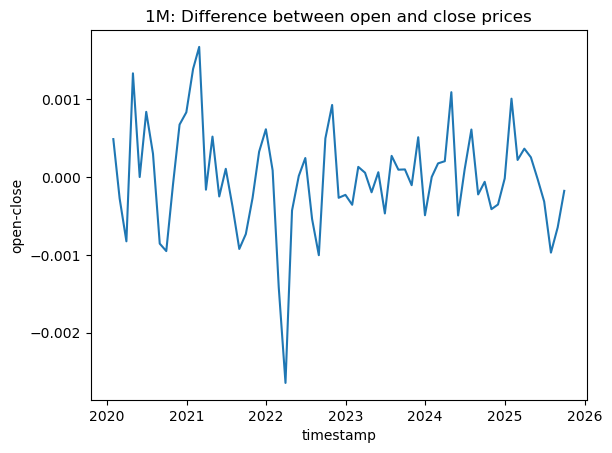

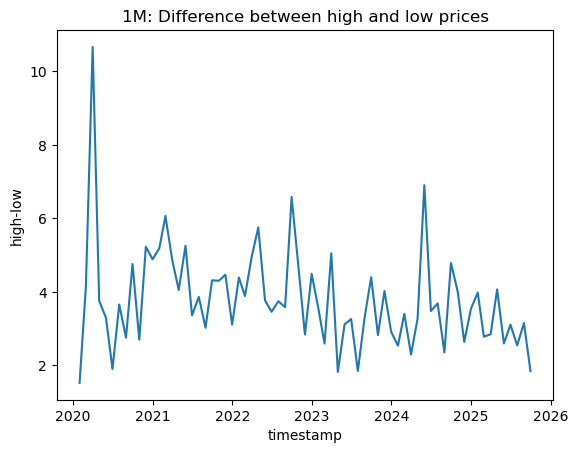

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


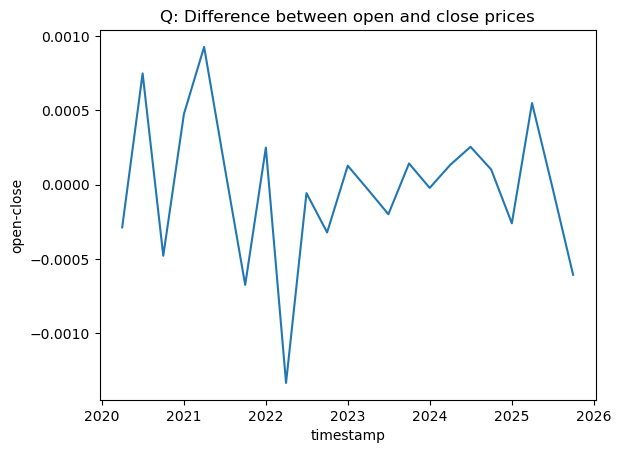

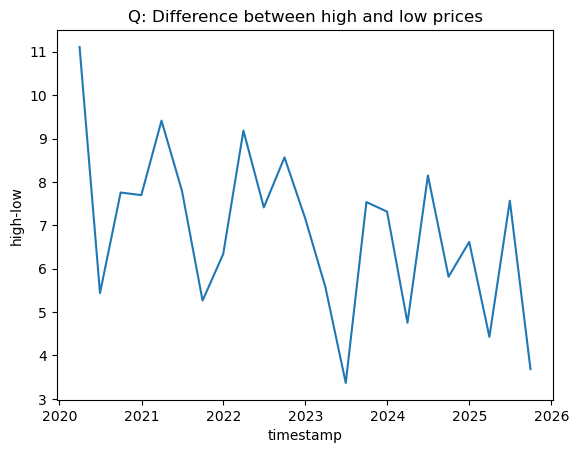

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


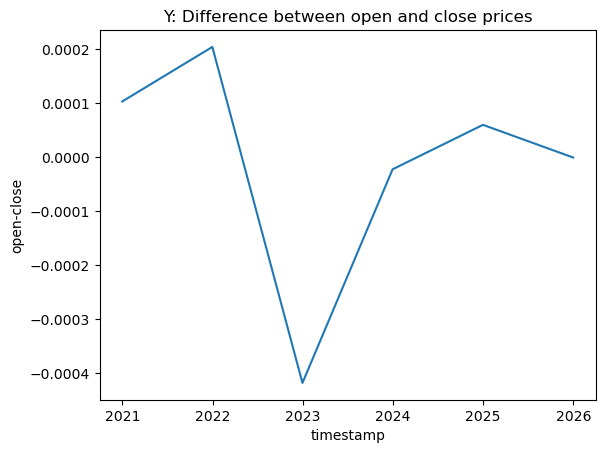

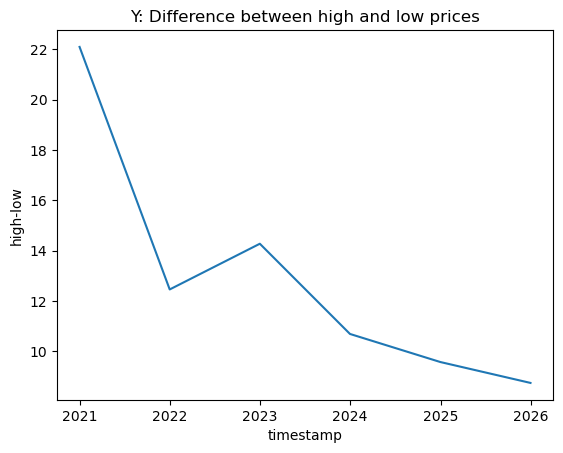

In [33]:
for inter in time_intervals:
    bep_ranges = volatility_df(bep_df, inter)

    plt.figure()
    sns.lineplot(data=bep_ranges, x='timestamp', y='open-close')
    plt.title(f'{inter}: Difference between open and close prices')
    plt.show()

    plt.figure()
    sns.lineplot(data=bep_ranges, x='timestamp', y='high-low')
    plt.title(f'{inter}: Difference between high and low prices')
    plt.show()

# Correlation

In [34]:
for lag in range(1,20):
    print(lag, pd.Series(daily_volatility_AAPL).autocorr(lag=lag))

1 0.5769805692458503
2 0.5453167336440363
3 0.4821113717639656
4 0.42744090257569606
5 0.3864652909470627
6 0.3525342140542362
7 0.34637349276087337
8 0.3158855263388463
9 0.3106950930319282
10 0.297291495594944
11 0.2688191606425518
12 0.23560465797148583
13 0.2358833454408587
14 0.21831307739680791
15 0.19106833843457732
16 0.19857795585558516
17 0.17201112496576124
18 0.16509769944055827
19 0.16609037639978244


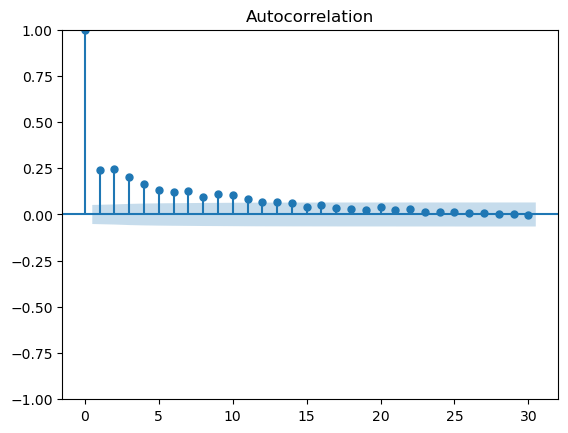

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_variance_AAPL, lags=30)

In [36]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_BEP).autocorr(lag=lag))

1 0.6837558923028522
2 0.6514615802746551
3 0.5983315496768644
4 0.5518487177894505
5 0.5174831319293282


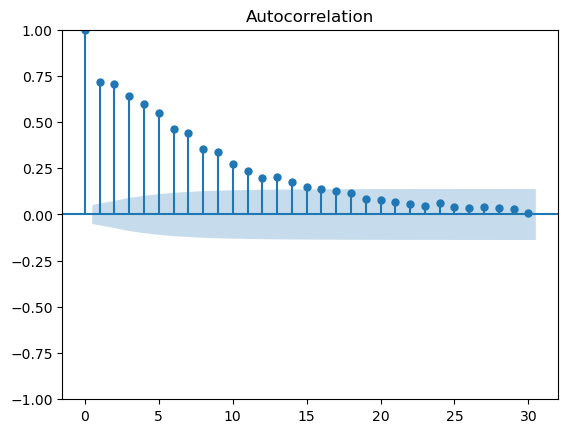

In [37]:
plot_acf(daily_variance_BEP, lags=30)

In [38]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_LLY).autocorr(lag=lag))

1 0.5470570909894626
2 0.48744389860830095
3 0.4214346943936259
4 0.3980873030426875
5 0.36517993620454686


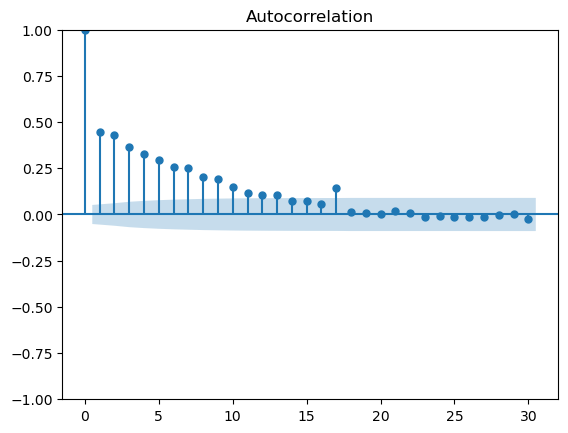

In [43]:
plot_acf(daily_variance_LLY, lags=30)
plt.show()

# EWMA

In [41]:
daily_volatility_AAPL

time_stamp
2020-01-02    0.000447
2020-01-03    0.000564
2020-01-06    0.000436
2020-01-07    0.000453
2020-01-08    0.000482
                ...   
2025-09-24    0.000509
2025-09-25    0.000627
2025-09-26    0.000486
2025-09-29    0.000423
2025-09-30    0.000454
Name: log_return, Length: 1444, dtype: float64

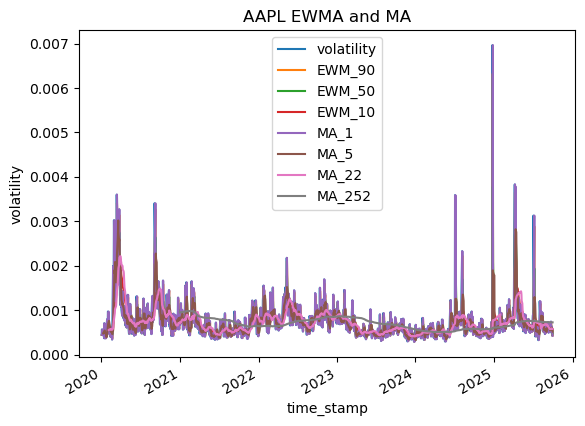

In [14]:
daily_volatility_AAPL.name = 'volatility'
daily_volatility_AAPL = daily_volatility_AAPL.to_frame()
daily_volatility_AAPL['EWM_90'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_AAPL['EWM_50'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_AAPL['EWM_10'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_AAPL['MA_1'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=1).mean()
daily_volatility_AAPL['MA_5'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=5).mean()
daily_volatility_AAPL['MA_22'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=22).mean()
daily_volatility_AAPL['MA_252'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=252).mean()
daily_volatility_AAPL.plot()
plt.title("AAPL EWMA and MA")
plt.ylabel("volatility")
plt.show()

In [15]:
moving_average_AAPL = {
    "MA_1": daily_volatility_AAPL['MA_1'],
    "MA_5": daily_volatility_AAPL['MA_5'],
    "MA_22": daily_volatility_AAPL['MA_22'],
    "MA_252": daily_volatility_AAPL['MA_252']
}

In [18]:
df = pd.DataFrame(moving_average_AAPL)
df.to_csv("AAPL_moving_average.csv.gz", compression="gzip")

In [30]:
# daily_volatility_BEP.name = 'volatility'
# daily_volatility_BEP = daily_volatility_BEP.to_frame()
# daily_volatility_BEP['EWM_90'] = daily_volatility_BEP['volatility'].shift(1).ewm(alpha=.90).mean()
# daily_volatility_BEP['EWM_50'] = daily_volatility_BEP['volatility'].shift(1).ewm(alpha=.50).mean()
# daily_volatility_BEP['EWM_10'] = daily_volatility_BEP['volatility'].shift(1).ewm(alpha=.10).mean()

moving_average = pd.DataFrame()
MA = ["1", "5", "22", "252"]
for window in MA:
    column_name = f"MA_{window}"
    moving_average[column_name] = daily_volatility_BEP['volatility'].shift(1).rolling(window=int(window)).mean()
    
# daily_volatility_BEP['MA_1'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=1).mean()
# daily_volatility_BEP['MA_5'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=5).mean()
# daily_volatility_BEP['MA_22'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=22).mean()
# daily_volatility_BEP['MA_252'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=252).mean()
# daily_volatility_BEP.plot()
# plt.title("BEP EWMA and MA")
# plt.ylabel("volatility")
# plt.show()

In [31]:
moving_average

MA_1      MA_5     MA_22    MA_252
time_stamp                                        
2020-01-02       NaN       NaN       NaN       NaN
2020-01-03  0.000495       NaN       NaN       NaN
2020-01-06  0.000529       NaN       NaN       NaN
2020-01-07  0.000438       NaN       NaN       NaN
2020-01-08  0.000570       NaN       NaN       NaN
...              ...       ...       ...       ...
2025-09-24  0.000871  0.000719  0.000723  0.000900
2025-09-25  0.000626  0.000727  0.000719  0.000899
2025-09-26  0.001182  0.000810  0.000743  0.000901
2025-09-29  0.000713  0.000805  0.000749  0.000902
2025-09-30  0.000610  0.000800  0.000748  0.000901

[1444 rows x 4 columns]

In [20]:
BEP_moving_average = {
    "MA_1": daily_volatility_BEP['MA_1'],
    "MA_5": daily_volatility_BEP['MA_5'],
    "MA_22": daily_volatility_BEP['MA_22'],
    "MA_252": daily_volatility_BEP['MA_252']
}
df = pd.DataFrame(BEP_moving_average)
df.to_csv("BEP_moving_average.csv.gz", compression="gzip")

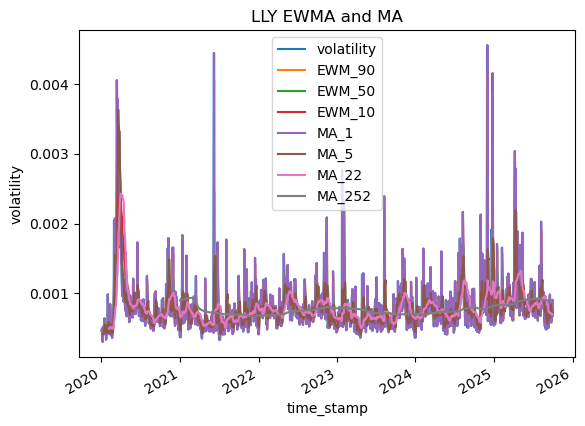

In [21]:
daily_volatility_LLY.name = 'volatility'
daily_volatility_LLY = daily_volatility_LLY.to_frame()
daily_volatility_LLY['EWM_90'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_LLY['EWM_50'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_LLY['EWM_10'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_LLY['MA_1'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=1).mean()
daily_volatility_LLY['MA_5'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=5).mean()
daily_volatility_LLY['MA_22'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=22).mean()
daily_volatility_LLY['MA_252'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=252).mean()
daily_volatility_LLY.plot()
plt.title("LLY EWMA and MA")
plt.ylabel("volatility")
plt.show()

In [22]:
moving_average_LLY = {
    "MA_1": daily_volatility_LLY['MA_1'],
    "MA_5": daily_volatility_LLY['MA_5'],
    "MA_22": daily_volatility_LLY['MA_22'],
    "MA_252": daily_volatility_LLY['MA_252']
}
df = pd.DataFrame(moving_average_LLY)
df.to_csv("LLY_moving_average.csv.gz", compression="gzip")

In [ ]:
#EWMA formula, acts as basis to compare other models
def ewma_predict_Days(volatility, lambda_, days, loss):
    predicted = []
    true = []
    start = len(volatility) - days
    # print(start)
    for i in range(start, len(volatility)):
        historical = volatility.iloc[:i]
        # print("historical: ", historical)
        ewma_value = historical.ewm(alpha=lambda_).mean().iloc[-1]
        # print("ewma value: ", ewma_value)
        true.append(volatility.iloc[i])
        predicted.append(ewma_value)
    # print(true)
    # print(predicted)
    if loss == "MSE":
        return np.mean((np.array(true)-np.array(predicted))**2)
    else:
        return None

In [ ]:
#Use ewma and find the error in predicting the latest 20 days
mse_APPL = ewma_predict_Days(daily_volatility_AAPL, 0.94, 20, "MSE")
print("MSE: ", mse_APPL)

MSE:  1.0911267691521766e-08


In [ ]:
mse_LLY = ewma_predict_Days(daily_volatility_LLY, 0.94, 20, "MSE")
print("MSE LLY: ", mse_LLY)

MSE LLY:  2.23307755951079e-08


In [ ]:
mse_BEP = ewma_predict_Days(daily_volatility_BEP, 0.94, 20, "MSE")
print("BEP MSE: ", mse_BEP)

BEP MSE:  5.497451390562223e-08


## EWMA hyperparam tuning w CV

In [4]:
def daily_volatility(df):
    """
    Aggregates to daily level and calculates volatility based on the 
    logic: sqrt(log(1 + (close - open) / open))
    """
    # Select columns and drop NAs
    df = df[['timestamp', 'open', 'close']].dropna().copy()
    
    # Convert timestamp to datetime and extract the date
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    
    # Group by date to get first open and last close
    daily = df.groupby('date').agg(
        open=('open', 'first'),
        close=('close', 'last')
    ).reset_index()
    
    # Calculate log return
    # equivalent to R: log(1 + (close - open) / open) -> log(close / open)
    daily['log_return'] = np.log(1 + (daily['close'] - daily['open']) / daily['open'])
    
    # Calculate volatility
    # Note: If log_return is negative, sqrt will result in NaN. 
    # We use np.sqrt where valid, otherwise NaN.
    daily['volatility'] = daily['log_return'].apply(lambda x: np.sqrt(x) if x > 0 else np.nan)
    
    # Return only date and volatility, dropping any rows where calculation failed (NaNs)
    return daily[['date', 'volatility']].dropna()

aapl_vol = daily_volatility(aapl_df)
nee_vol = daily_volatility(nee_df)
lly_vol = daily_volatility(lly_df)

# Outlier Detection

In [ ]:
df_AAPL = pd.read_csv("data_files/AAPL_combined.csv.gz")
AAPL_returns = pd.DataFrame({
    "time_stamp": df_AAPL["Unnamed: 0"],
    "log_return": np.log(1+(df_AAPL['4. close']-df_AAPL['1. open'])/df_AAPL['1. open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()


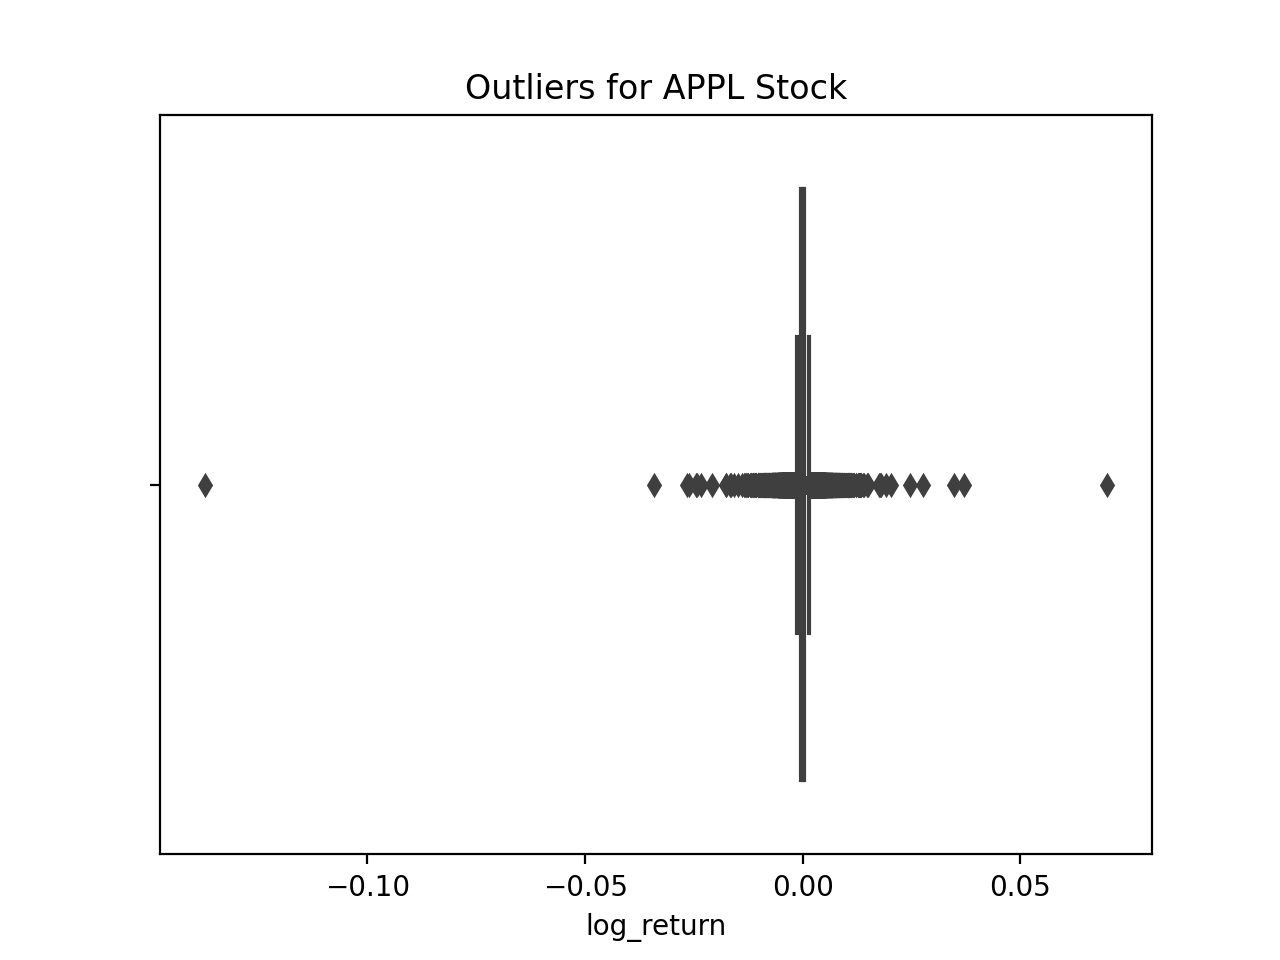

In [ ]:
sns.boxplot(x="log_return", data=AAPL_returns)
plt.title("Outliers for APPL Stock")
plt.show()

In [ ]:
lower_bound = AAPL_returns["log_return"].quantile(0.0125)
upper_bound = AAPL_returns["log_return"].quantile(0.9875)
AAPL_returns_filtered = AAPL_returns[(AAPL_returns["log_return"] >= lower_bound) & (AAPL_returns["log_return"] <= upper_bound)]
daily_variance_AAPL_filtered = AAPL_returns_filtered.groupby(AAPL_returns_filtered['time_stamp'].dt.floor("1D"))["log_return"].var()

In [ ]:
#Plot returns
AAPL_returns_filtered.set_index("time_stamp", inplace=True)
AAPL_returns_filtered.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns Filtered")

Text(0.5, 1.0, 'Apple Returns Filtered')

In [ ]:
#Plot variance
plt.plot(daily_variance_AAPL_filtered.index, daily_variance_AAPL_filtered.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance Filtered")

Text(0.5, 1.0, 'Apple Variance Filtered')

In [ ]:
#Plot volatility
daily_volatility_AAPL_filtered = np.sqrt(daily_variance_AAPL_filtered)
plt.plot(daily_volatility_AAPL_filtered.index, daily_volatility_AAPL_filtered.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Apple Volatility Filtered")

Text(0.5, 1.0, 'Apple Volatility Filtered')

In [ ]:
#Use ewma and find the error in predicting the latest 20 days
mse_APPL = ewma_predict_Days(daily_volatility_AAPL_filtered, 0.94, 20, "MSE")
print("MSE: ", mse_APPL)

MSE:  7.772117950190128e-09


In [ ]:
df = pd.read_csv("data_files/BEP_combined.csv.gz")
df.columns
BEP_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
BEP_returns['time_stamp'] = pd.to_datetime(BEP_returns['time_stamp'], errors='coerce')
daily_variance_BEP = BEP_returns.groupby(BEP_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

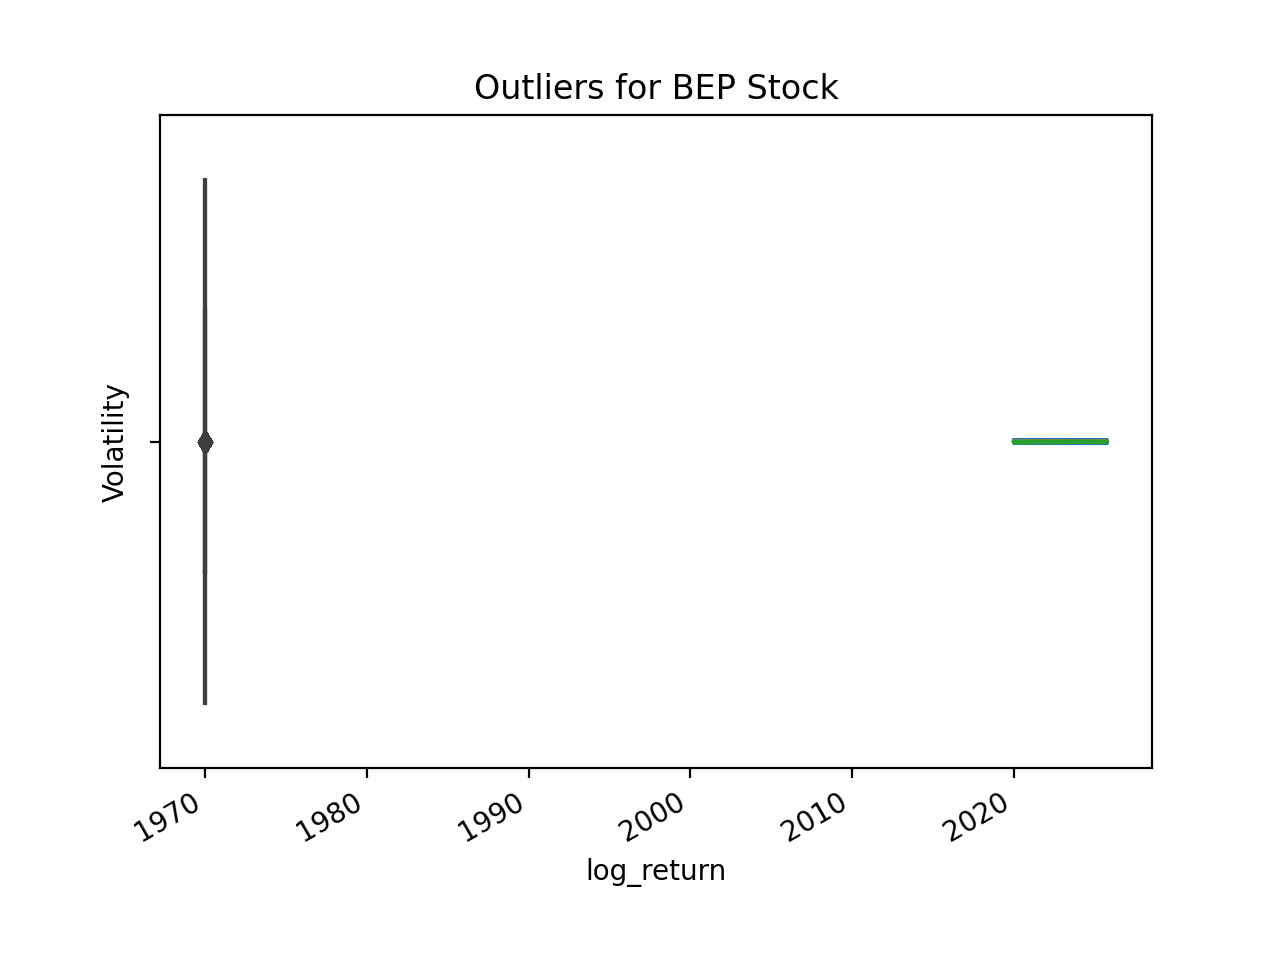

In [ ]:
sns.boxplot(x="log_return", data=BEP_returns)
plt.title("Outliers for BEP Stock")
plt.show()

In [ ]:
lower_bound = BEP_returns["log_return"].quantile(0.0125)
upper_bound = BEP_returns["log_return"].quantile(0.9875)
BEP_returns_filtered = BEP_returns[(BEP_returns["log_return"] >= lower_bound) & (BEP_returns["log_return"] <= upper_bound)]
daily_variance_BEP_filtered = BEP_returns_filtered.groupby(BEP_returns_filtered['time_stamp'].dt.floor("1D"))["log_return"].var()

In [ ]:
BEP_returns_filtered.set_index("time_stamp", inplace=True)
BEP_returns_filtered.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("BEP Returns Filtered")

Text(0.5, 1.0, 'BEP Returns Filtered')

In [ ]:
plt.plot(daily_variance_BEP_filtered.index, daily_variance_BEP_filtered.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("BEP Variance Filtered")

Text(0.5, 1.0, 'BEP Variance Filtered')

In [ ]:
daily_volatility_BEP_filtered = np.sqrt(daily_variance_BEP_filtered)
plt.plot(daily_volatility_BEP_filtered.index, daily_volatility_BEP_filtered.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("BEP Volatility filtered")

Text(0.5, 1.0, 'BEP Volatility filtered')

In [ ]:
mse_BEP = ewma_predict_Days(daily_volatility_BEP_filtered, 0.94, 20, "MSE")
print("BEP Filtered MSE: ", mse_BEP)

BEP Filtered MSE:  1.361859327667227e-08


In [ ]:
df = pd.read_csv("data_files/LLY_combined.csv.gz")
df.columns
LLY_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

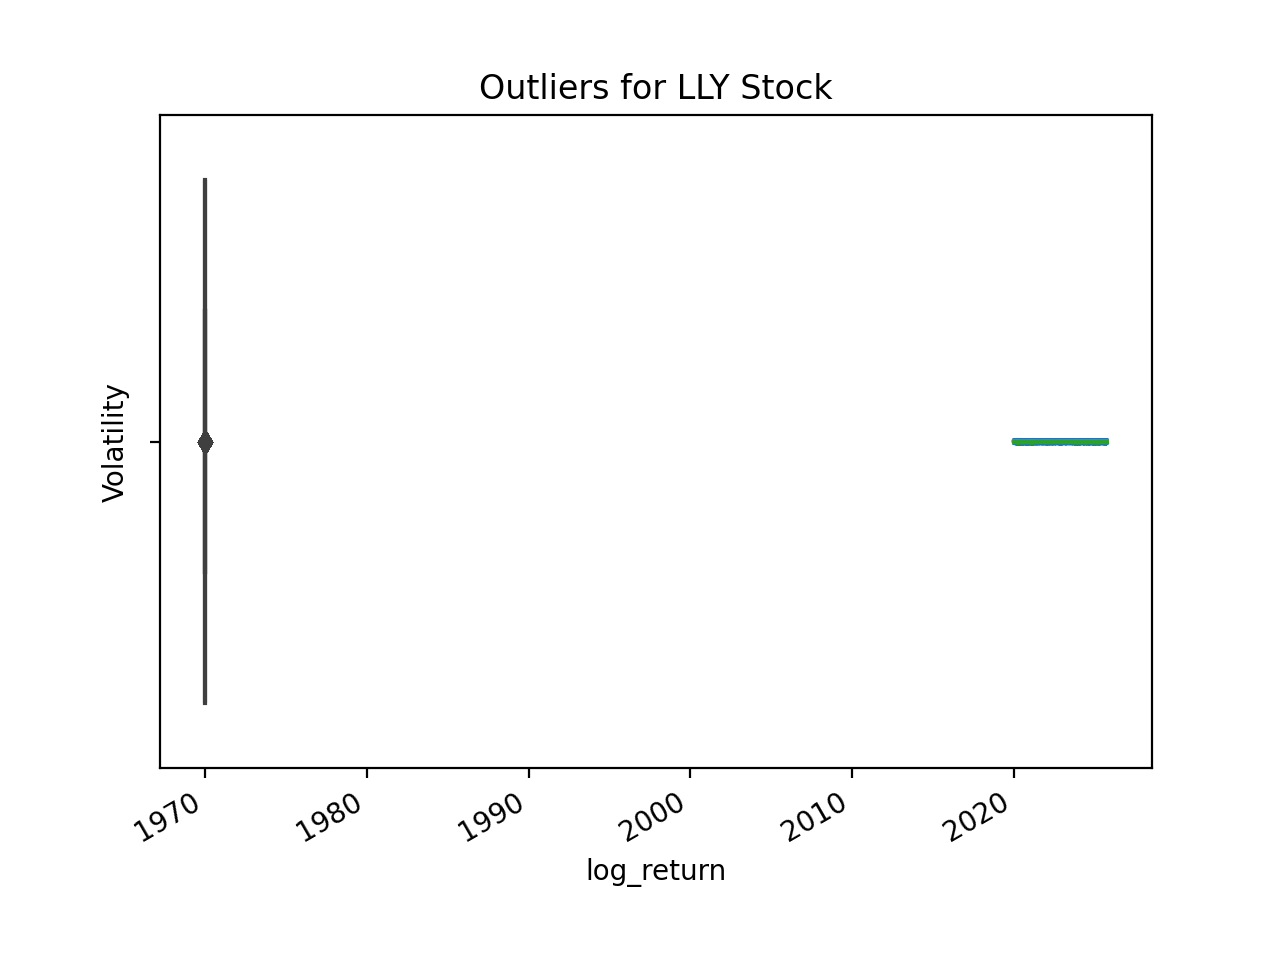

In [ ]:
sns.boxplot(x="log_return", data=LLY_returns)
plt.title("Outliers for LLY Stock")
plt.show()

In [ ]:
lower_bound = LLY_returns["log_return"].quantile(0.0125)
upper_bound = LLY_returns["log_return"].quantile(0.9875)
LLY_returns_filtered = LLY_returns[(LLY_returns["log_return"] >= lower_bound) & (LLY_returns["log_return"] <= upper_bound)]
daily_variance_LLY_filtered = LLY_returns_filtered.groupby(LLY_returns_filtered['time_stamp'].dt.floor("1D"))["log_return"].var()

In [ ]:
LLY_returns_filtered.set_index("time_stamp", inplace=True)
LLY_returns_filtered.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns Filtered")

Text(0.5, 1.0, 'LLY Returns Filtered')

In [ ]:
plt.plot(daily_variance_LLY_filtered.index, daily_variance_LLY_filtered.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance Filtered")

Text(0.5, 1.0, 'LLY Variance Filtered')

In [ ]:
daily_volatility_LLY_filtered = np.sqrt(daily_variance_LLY_filtered)
plt.plot(daily_volatility_LLY_filtered.index, daily_volatility_LLY_filtered.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility Filtered")

Text(0.5, 1.0, 'LLY Volatility Filtered')

In [ ]:
mse_LLY = ewma_predict_Days(daily_volatility_LLY_filtered, 0.94, 20, "MSE")
print("MSE Filtered LLY: ", mse_LLY)

MSE Filtered LLY:  8.297770244358856e-09


# Baseline Models

1. EWMA
2. ARIMA
3. GARCH

### EWMA

In [10]:
class EWMAResults:

    def __init__(self, data, lambda_val):
        self._data = data
        self._lambda = lambda_val
    
        self.conditional_volatility = data.ewm(alpha=lambda_val, adjust=False).mean()
        self.resid = data - self.conditional_volatility

    def summary(self):
        print("EWMA Model Results")
        print("==================")
        print(f"Lambda (alpha): {self._lambda}")
        print(f"Last Volatility: {self.conditional_volatility.iloc[-1]:.5f}")
        return ""

    def forecast(self, horizon=1):
        last_vol = self.conditional_volatility.iloc[-1]

        class ForecastObj:
            def __init__(self, val, h):
                self.volatility = pd.Series([val] * h, name='h.1')
                self.variance = self.volatility ** 2
        
        return ForecastObj(last_vol, horizon)
    
def fit_ewma(df, lambda_):

    series = df['volatility'] 
    
    results = EWMAResults(series, lambda_)
    
    return results

def find_best_lambda_cv(vol_series, n_splits=5):

    lambdas = np.linspace(0.01, 0.99, 50)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    avg_rmse_scores = []
    
    print(f"--- Hyper-tuning Lambda with {n_splits}-Fold CV ---")
    
    for lam in lambdas:
        fold_rmses = []
        
        for train_index, test_index in tscv.split(vol_series):
            # Split data
            train = vol_series.iloc[train_index]
            test = vol_series.iloc[test_index]

            train_ewma = train.ewm(alpha=lam, adjust=False).mean()
            last_train_vol = train_ewma.iloc[-1]
            
            full_chunk = vol_series.iloc[np.concatenate([train_index, test_index])]
            full_ewma = full_chunk.ewm(alpha=lam, adjust=False).mean()
            
            predictions = full_ewma.shift(1).iloc[test_index]
            
            actuals = test
            
            valid = ~np.isnan(predictions)
            rmse = np.sqrt(mean_squared_error(actuals[valid], predictions[valid]))
            fold_rmses.append(rmse)
        
        avg_rmse_scores.append(np.mean(fold_rmses))

    best_idx = np.argmin(avg_rmse_scores)
    best_lambda = lambdas[best_idx]
    best_score = avg_rmse_scores[best_idx]
    
    return best_lambda


In [12]:
best_lam = find_best_lambda_cv(aapl_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found aapl: {best_lam:.3f}")
best_lam = find_best_lambda_cv(nee_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found nee: {best_lam:.3f}")
best_lam = find_best_lambda_cv(lly_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found lly: {best_lam:.3f}")

--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found aapl: 0.050
--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found nee: 0.010
--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found lly: 0.010


In [13]:
aapl_ewma = fit_ewma(aapl_vol, lambda_ = 0.05)
nee_ewma = fit_ewma(nee_vol, lambda_= 0.01)
lly_ewma = fit_ewma(lly_vol, lambda_ = 0.01)

### ARIMA

In [7]:
def fit_and_plot_arima(df, name):
    print(f"--- Auto ARIMA for {name} ---")

    # Make data a series
    series = df['volatility'].values
    
    # Model
    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)
    print(model.summary())
    
    # Forecast
    n_periods = 30
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, n_periods + 1)]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], series[-100:], label='Last 100 observed days') # historic
    plt.plot(forecast_dates, forecast, label='Forecast', color='green') # forecast
    plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.3)
    plt.title(f"{name} Volatility Forecast")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

--- Auto ARIMA for AAPL ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  775
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1305.051
Date:                Wed, 10 Dec 2025   AIC                          -2606.102
Time:                        23:19:52   BIC                          -2596.799
Sample:                             0   HQIC                         -2602.523
                                - 775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9425      0.011    -82.846      0.000      -0.965      -0.920
sigma2         0.0020   7.28e-05     27.529      0.000       0.002       0.002
Ljung-Box (L1) (Q):     

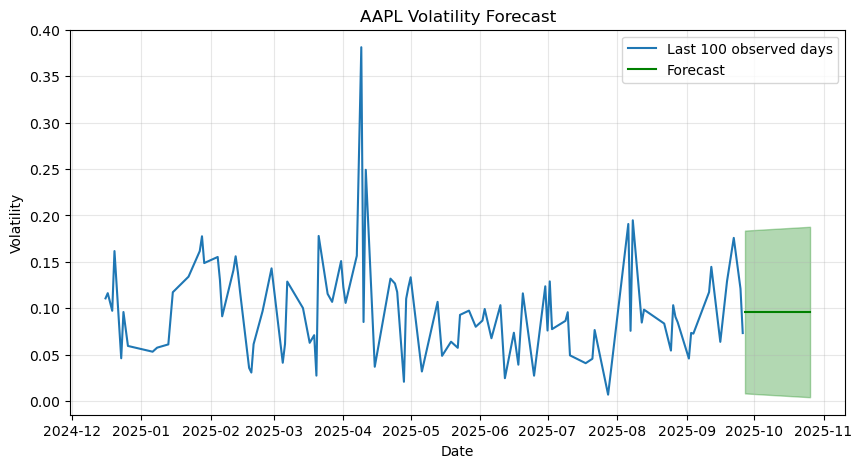

--- Auto ARIMA for NEE ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  746
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1266.845
Date:                Wed, 10 Dec 2025   AIC                          -2525.691
Time:                        23:19:56   BIC                          -2507.232
Sample:                             0   HQIC                         -2518.576
                                - 746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.005      1.890      0.059      -0.000       0.020
ar.L1          0.8948      0.055     16.174      0.000       0.786       1.003
ma.L1         -0.8233    

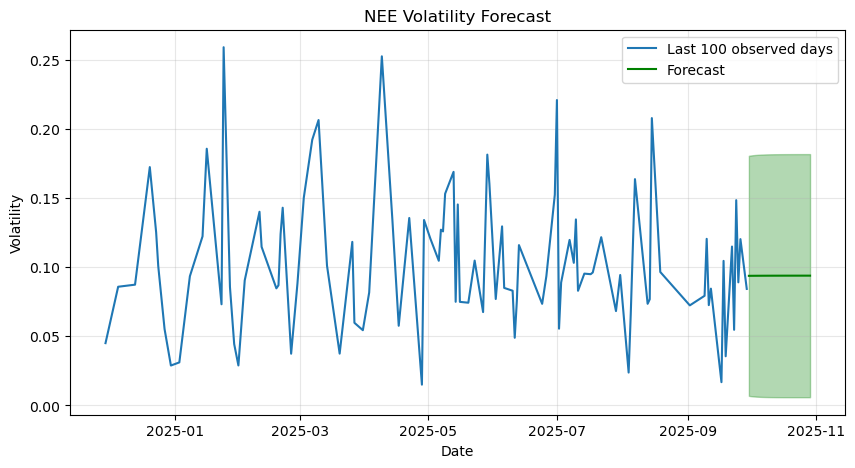

--- Auto ARIMA for LLY ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1246.578
Date:                Wed, 10 Dec 2025   AIC                          -2485.156
Time:                        23:20:00   BIC                          -2466.644
Sample:                             0   HQIC                         -2478.025
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0129      0.007      1.928      0.054      -0.000       0.026
ar.L1          0.8676      0.068     12.697      0.000       0.734       1.002
ma.L1         -0.7805    

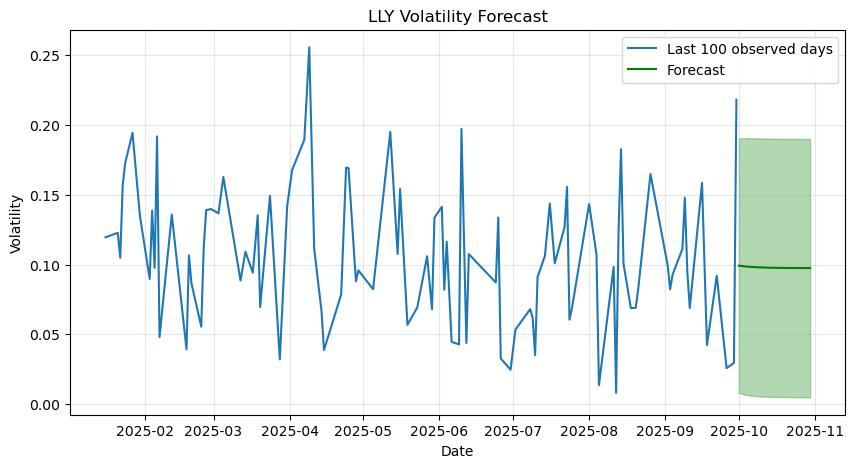

In [8]:
fit_and_plot_arima(aapl_vol, "AAPL")
fit_and_plot_arima(nee_vol, "NEE")
fit_and_plot_arima(lly_vol, "LLY")

In [9]:
def fit_arima(df):

    series = df['volatility'].values

    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)

    return model

aapl_arima = fit_arima(aapl_vol)
nee_arima = fit_arima(nee_vol)
lly_arima = fit_arima(lly_vol)

### GARCH

In [14]:

def optimize_garch_cv(returns_series, n_splits=5):
    """
    Finds best p, q using Time Series Cross-Validation.
    Metric: MSE of (Predicted Variance - Actual Squared Returns).
    """
    
    # 1. Setup Grid
    p_range = [1, 2, 3]
    q_range = [1, 2, 3]
    
    # 2. Setup Time Series Split
    # This ensures we never look ahead in time
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = []

    print(f"{'p':<4} {'q':<4} {'Avg MSE':<15}")
    print("-" * 30)

    # 3. Grid Search Loop
    for p in p_range:
        for q in q_range:
            mse_scores = []
            
            # 4. CV Loop (The "Folds")
            for train_idx, test_idx in tscv.split(returns_series):
                # Split data
                train_data = returns_series.iloc[train_idx]
                test_data = returns_series.iloc[test_idx]
                
                # Fit Model on TRAIN data only
                # We use disp='off' to silence the training output
                try:
                    model = arch_model(train_data, vol='Garch', p=p, q=q, mean='Zero')
                    res = model.fit(disp='off')
                    
                    # Forecast the volatility for the TEST period
                    # horizon=len(test_data) predicts N steps into the future
                    forecasts = res.forecast(horizon=len(test_data), reindex=False)
                    
                    # Get predicted variance
                    # Note: We take the last forecasted row because in a static forecast, 
                    # we project from the last known data point.
                    pred_variance = forecasts.variance.values[-1]
                    
                    # Calculate 'True' proxy (Squared Returns of test set)
                    # We are comparing Variance to Squared Returns
                    actual_variance_proxy = test_data ** 2
                    
                    # Calculate MSE for this fold
                    mse = mean_squared_error(actual_variance_proxy, pred_variance)
                    mse_scores.append(mse)
                    
                except:
                    # If model fails to converge, ignore this param set
                    continue
            
            # Average score across all folds
            if mse_scores:
                avg_mse = np.mean(mse_scores)
                results.append({'p': p, 'q': q, 'score': avg_mse})
                print(f"{p:<4} {q:<4} {avg_mse:.4f}")

    # 5. Find Best Result
    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['score'].idxmin()]
    
    print("-" * 30)
    print(f"BEST PARAMS via CV: p={int(best_params.p)}, q={int(best_params.q)}")
    return int(best_params.p), int(best_params.q)

In [16]:
aapl_vol_rescale = aapl_vol.copy()
aapl_vol_rescale['volatility'] = aapl_vol_rescale['volatility'] * 10

nee_vol_rescale = nee_vol.copy()
nee_vol_rescale['volatility'] = nee_vol_rescale['volatility'] * 10

lly_vol_rescale = lly_vol.copy()
lly_vol_rescale['volatility'] = lly_vol_rescale['volatility'] * 10


In [17]:

print("------ GARCH for AAPL -------")
best_p, best_q = optimize_garch_cv(aapl_vol_rescale['volatility'])
aapl_garch = arch_model(aapl_vol_rescale['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
aapl_res = aapl_garch.fit(disp='off')
print(aapl_res.summary())


------ GARCH for AAPL -------
p    q    Avg MSE        
------------------------------
1    1    1.2167
1    2    1.2174
1    3    1.2189
2    1    1.2182
2    2    1.2186
2    3    1.2172
3    1    1.2182
3    2    1.2216
3    3    1.2171
------------------------------
BEST PARAMS via CV: p=1, q=1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1151.46
Distribution:                  Normal   AIC:                           2308.92
Method:            Maximum Likelihood   BIC:                           2322.88
                                        No. Observations:                  775
Date:                Wed, Dec 10 2025   Df Residuals:                      775
Time:                        23:25:28   Df Model:                   

In [18]:

print("------ GARCH for NEE -------")
best_p, best_q = optimize_garch_cv(nee_vol_rescale['volatility'])
nee_garch = arch_model(nee_vol_rescale['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
nee_res = nee_garch.fit(disp='off')
print(nee_res.summary())


------ GARCH for NEE -------
p    q    Avg MSE        
------------------------------
1    1    0.9116
1    2    0.9116
1    3    0.9124
2    1    0.9105
2    2    0.9073
2    3    0.9060
3    1    0.9091
3    2    0.9072
3    3    0.9061
------------------------------
BEST PARAMS via CV: p=2, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1081.09
Distribution:                  Normal   AIC:                           2174.17
Method:            Maximum Likelihood   BIC:                           2201.86
                                        No. Observations:                  746
Date:                Wed, Dec 10 2025   Df Residuals:                      746
Time:                        23:25:31   Df Model:                    

In [19]:

print("------ GARCH for LLY -------")
best_p, best_q = optimize_garch_cv(lly_vol_rescale['volatility'])
lly_garch = arch_model(lly_vol_rescale['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
lly_res = lly_garch.fit(disp='off')
print(lly_res.summary())

------ GARCH for LLY -------
p    q    Avg MSE        
------------------------------
1    1    1.0461
1    2    1.0461
1    3    1.0461
2    1    1.0458
2    2    1.0454
2    3    1.0448
3    1    1.0448
3    2    1.0447
3    3    1.0429
------------------------------
BEST PARAMS via CV: p=3, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1130.76
Distribution:                  Normal   AIC:                           2275.52
Method:            Maximum Likelihood   BIC:                           2307.92
                                        No. Observations:                  756
Date:                Wed, Dec 10 2025   Df Residuals:                      756
Time:                        23:25:35   Df Model:                    


--- Fitting GARCH(1,1) for AAPL ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                633.042
Distribution:                  Normal   AIC:                          -1260.08
Method:            Maximum Likelihood   BIC:                          -1246.13
                                        No. Observations:                  775
Date:                Wed, Dec 10 2025   Df Residuals:                      775
Time:                        23:27:18   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.4402e

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002121. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.



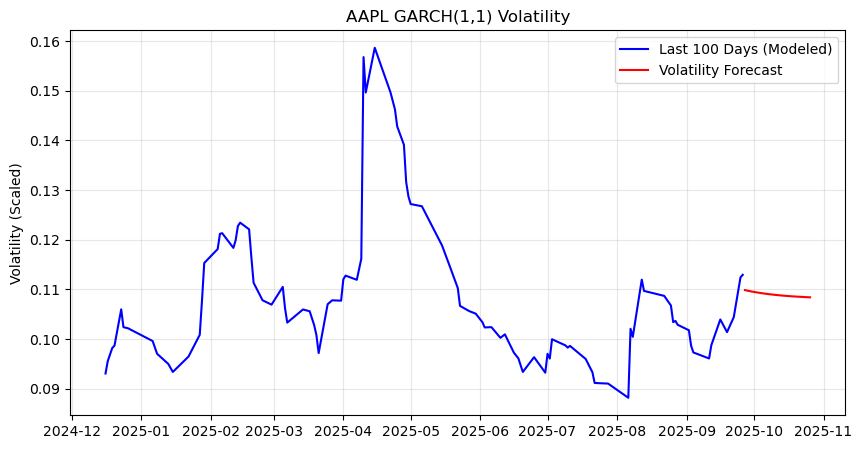


--- Fitting GARCH(1,1) for NEE ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                635.904
Distribution:                  Normal   AIC:                          -1265.81
Method:            Maximum Likelihood   BIC:                          -1251.96
                                        No. Observations:                  746
Date:                Wed, Dec 10 2025   Df Residuals:                      746
Time:                        23:27:18   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.2175e-04 

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002037. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.



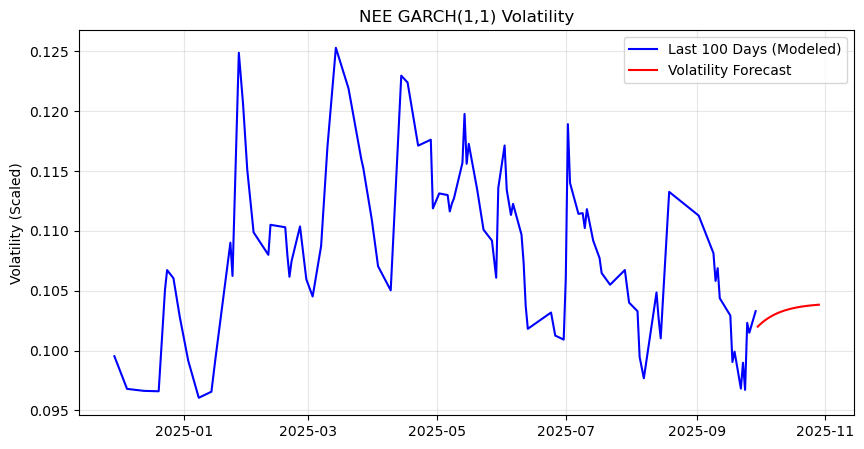


--- Fitting GARCH(1,1) for LLY ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                609.848
Distribution:                  Normal   AIC:                          -1213.70
Method:            Maximum Likelihood   BIC:                          -1199.81
                                        No. Observations:                  756
Date:                Wed, Dec 10 2025   Df Residuals:                      756
Time:                        23:27:18   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8741e-

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002228. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.



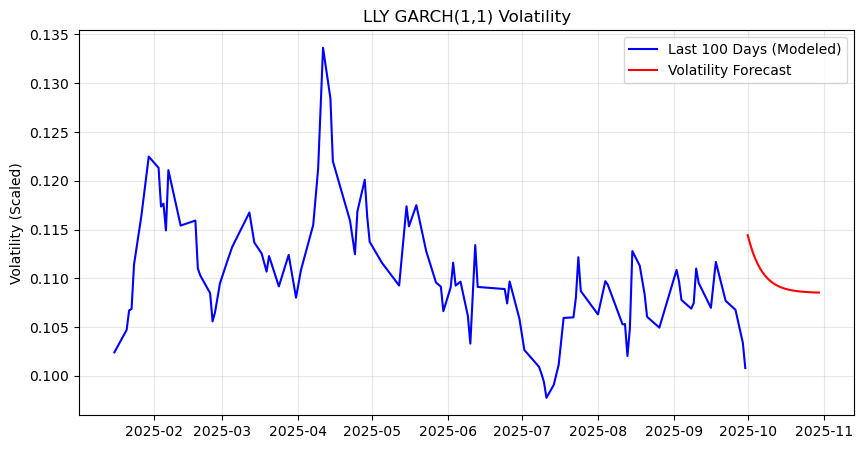

In [21]:
def fit_and_forecast_garch(df, ticker_name):
    print(f"\n--- Fitting GARCH(1,1) for {ticker_name} ---")
    
    # Model
    model = arch_model(df['volatility'], vol='Garch', p=1, q=1, mean='Zero')
    results = model.fit(disp='off')
    print(results.summary())
    
    # Forecast
    forecast_horizon = 30
    forecasts = results.forecast(horizon=forecast_horizon)
    pred_variance = forecasts.variance.values[-1, :]
    pred_volatility = np.sqrt(pred_variance)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, forecast_horizon + 1)]
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], results.conditional_volatility[-100:], label='Last 100 Days (Modeled)', color='blue') #historic
    plt.plot(forecast_dates, pred_volatility, label='Volatility Forecast', color='red') #forecast
    plt.title(f"{ticker_name} GARCH(1,1) Volatility")
    plt.ylabel("Volatility (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

fit_and_forecast_garch(aapl_vol, "AAPL")
fit_and_forecast_garch(nee_vol, "NEE")
fit_and_forecast_garch(lly_vol, "LLY")


In [20]:
def fit_garch_pq(df, p, q):    
    # Model
    model = arch_model(df['volatility'], vol='Garch', p=p, q=q, mean='Zero')
    results = model.fit(disp='off')

    return results

aapl_garch = fit_garch_pq(aapl_vol, 1, 1)
nee_garch = fit_garch_pq(nee_vol, 3, 2)
lly_garch = fit_garch_pq(lly_vol, 3, 3)

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002121. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002037. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python

### Model Comparison

In [22]:
def compare_models(ticker_name, ewma_res, arima_res, garch_res, original_data):
    """
    Compares EWMA, ARIMA, and GARCH models.
    """
    metrics = {}
    
    # EWMA
    ewma_rmse = np.sqrt(np.mean(ewma_res.resid**2))
    metrics['EWMA'] = {'AIC': np.nan, 'BIC': np.nan, 'RMSE': ewma_rmse}

    # ARIMA

    arima_rmse = np.sqrt(np.mean(arima_res.resid()**2))
    metrics['ARIMA'] = {'AIC': arima_res.aic(), 'BIC': arima_res.bic(), 'RMSE': arima_rmse}

    # GARCH
    garch_rmse = np.sqrt(mean_squared_error(original_data, garch_res.conditional_volatility))
    metrics['GARCH'] = {'AIC': garch_res.aic, 'BIC': garch_res.bic, 'RMSE': garch_rmse}
    
    # Create DataFrame
    df_metrics = pd.DataFrame(metrics).T
    print(f"--- Model Comparison for {ticker_name} ---")
    display(df_metrics)
    return df_metrics

# Run the comparison
# Ensure you pass the Series used to fit the model as 'original_data'
aapl_comparison = compare_models("AAPL", aapl_ewma, aapl_arima, aapl_garch, aapl_vol['volatility'])
nee_comparison = compare_models("NEE", nee_ewma, nee_arima, nee_garch, nee_vol['volatility'])
lly_comparison = compare_models("LLY", lly_ewma, lly_arima, lly_garch, lly_vol['volatility'])

--- Model Comparison for AAPL ---


AIC          BIC      RMSE
EWMA           NaN          NaN  0.042498
ARIMA -2606.102279 -2596.799136  0.045038
GARCH -1260.083671 -1246.125082  0.045496

--- Model Comparison for NEE ---


AIC          BIC      RMSE
EWMA           NaN          NaN  0.044844
ARIMA -2525.690828 -2507.231926  0.044283
GARCH -1259.948386 -1232.260032  0.045117

--- Model Comparison for LLY ---


AIC          BIC      RMSE
EWMA           NaN          NaN  0.048349
ARIMA -2485.155743 -2466.643577  0.046520
GARCH -1205.989533 -1173.593243  0.047553

Based on AIC and BIC, ARIMA is better for AAPL, NEE, and LLY.

Based on RMSE, EWMA is the best for AAPL, ARIMA is best for NEE, and ARIMA is best for LLY.

Due to these results, we can conclude that ARIMA is the best baseline model

# Next Steps

Next Steps:
Want to incorporate secondary data to better predict volatility.
We plan to base our approach off of Trading Volume Alpha paper.
Model will consist of 4 kinds of features

Lagged moving averages of returns (as we did originally using EWMA),
fundamental characteristics of each stock: market equity, standardized earnings surprise, book leverage, book-to-market equity, Dimson beta, and firm age, calendar Dates that effect trading volume: Early closing, triple witching days, double witching days, Russell index re-balancing, earnings release schedule (using one hot encoding) for if a stock has an upcoming earnings release or has just had one

We will use a simple neural network model with three fully connected hidden layers of 32, 16, and 8 ReLU nodes and one linear output node.

We will evaluate the model using MSE and compare its performance with the EWMA.


References:
Goyenko, Ruslan and Kelly, Bryan T. and Moskowitz, Tobias J. and Moskowitz, Tobias J. and Su, Yinan and Zhang, Chao, Trading Volume Alpha (May 15, 2024). Available at SSRN: https://ssrn.com/abstract=4802345 or http://dx.doi.org/10.2139/ssrn.4802345
https://saltfinancial.com/static/uploads/2021/05/The%20Laymans%20Guide%20to%20Volatility%20Forecasting.pdf